<a href="https://colab.research.google.com/github/Ryandry1st/Machine-Learning/blob/master/DL_Hands_On.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###This notebook will be used as a general template for storing notes from *Machine Learning with Scikit-Learn and Tensorflow 2* by Aur$\acute{e}$lion G$\acute{e}$ron from the deep learning section. It will be purely NN based information and each subsection will have a summary to skip from vanilla to cnn and rnn, but there are good topics along the way which are worth checking out. There are also three datasets, a regression, binary classification, and multiclass classification for various testing methods. Further methods are explored at the end as an *in progress* work.

In [0]:
import os, sys
print(os.name, sys.version)
!nvidia-smi

posix 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Tue Jul 30 20:50:07 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------------------------------------------------------------

# Setup

## Tensorflow

In [0]:
#!pip install --upgrade matplotlib
#!pip install tf-nightly-gpu
!pip install tensorflow-gpu==2.0.0-beta1

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)
tf.random.set_seed(42)


print(tf.__version__, tf.executing_eagerly())
K.set_floatx('float32')
K.set_epsilon(1e-7)

     |████████████████████████████████| 348.9MB 53kB/s 
     |████████████████████████████████| 501kB 45.1MB/s 
     |████████████████████████████████| 3.1MB 33.5MB/s 
2.0.0-beta1 True


In [0]:
# not currently working see issue in https://github.com/tensorflow/transform/issues/123

# !pip install tensorflow_transform
# import tensorflow_transform as tft

## Tensorboard

Setting up tensorboard requires routing the local address to the current used computer, which can be done with ngrok and a few simple lines

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-06-24 18:41:17--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.54.84.112, 52.72.230.122, 54.173.32.212, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.54.84.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17556757 (17M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  16.74M  6.37MB/s    in 2.6s    

2019-06-24 18:41:20 (6.37 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [17556757/17556757]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://7eb47370.ngrok.io


The address above will allow for viewing tensorboard, however no models have been trained yet so that will not do anything yet.

In [0]:
import time
import os

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(LOG_DIR, run_id)

# Data Loading

A number of different datasets can be found here, I will start with just some simple ones available through tensorflow datasets

In [0]:
import tensorflow_datasets as tfds
print(tfds.list_builders())

['abstract_reasoning', 'bair_robot_pushing_small', 'bigearthnet', 'caltech101', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_corrupted', 'clevr', 'cnn_dailymail', 'coco2014', 'colorectal_histology', 'colorectal_histology_large', 'curated_breast_imaging_ddsm', 'cycle_gan', 'diabetic_retinopathy_detection', 'downsampled_imagenet', 'dsprites', 'dtd', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'eurosat', 'fashion_mnist', 'flores', 'glue', 'groove', 'higgs', 'horses_or_humans', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imdb_reviews', 'iris', 'kitti', 'kmnist', 'lm1b', 'lsun', 'mnist', 'moving_mnist', 'multi_nli', 'nsynth', 'omniglot', 'open_images_v4', 'oxford_flowers102', 'oxford_iiit_pet', 'para_crawl', 'patch_camelyon', 'quickdraw_bitmap', 'resisc45', 'rock_paper_scissors', 'shapes3d', 'smallnorb', 'snli', 'so2sat', 'squad', 'starcraft_video', 'sun397', 'super_glue', 'svhn_cropped', 'ted_hrlr_translate', 'ted_

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import requests, zipfile, io, os
from sklearn.model_selection import train_test_split


# Fashion MNIST
dataset, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True)
class_train, class_test = dataset['train'], dataset['test']

def scaling(image, label):
    image = tf.cast(image, tf.float16)
    image /= 255.0
    return image, label

class_train = class_train.map(scaling).shuffle(10000).batch(64)
class_test = class_test.map(scaling).batch(64)
class_train = class_train.prefetch(tf.data.experimental.AUTOTUNE)
class_test = class_test.prefetch(tf.data.experimental.AUTOTUNE)



# Census Dataset
columns = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital',
           'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
           'hours_week', 'native_country', 'label']
path = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
path_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

df = pd.read_csv(path, skipinitialspace = True, names = columns, index_col=False)
bin_test = pd.read_csv(path_test, skiprows=1, skipinitialspace = True, names = columns, index_col=False)

df = df.drop('education', axis=1)
bin_test = bin_test.drop('education', axis=1)
categoricals = ['workclass', 'marital', 'occupation', 'relationship', 'race', 'sex', 'native_country']

bin_train_labels = []
for i in range(len(df)):
    if df['label'][i] == '>50K':
        bin_train_labels.append(1)
    else:
        bin_train_labels.append(0)
bin_train_labels = np.array(bin_train_labels)

bin_test_labels = []
for i in range(len(bin_test)):
    if bin_test['label'][i] == '>50K.':
        bin_test_labels.append(1)
    else:
        bin_test_labels.append(0)
bin_test_labels = np.array(bin_test_labels)

df = pd.get_dummies(df.drop(['label'], axis=1), columns=categoricals)
bin_test = pd.get_dummies(bin_test.drop(['label'], axis=1), columns=categoricals)

if 'native_country_Holand-Netherlands' in bin_test.columns:
    bin_test = bin_test.drop(['native_country_Holand-Netherlands'], axis=1)
bin_test.insert(bin_test.columns.get_loc('native_country_Honduras'), 'native_country_Holand-Netherlands', value=0)

bin_train_x = np.array(df.values, dtype='float32')
bin_train_y = bin_train_labels
del bin_train_labels
bin_test_x = np.array(bin_test.values, dtype='float32')
bin_test_y = bin_test_labels
del bin_test_labels
scaler = MinMaxScaler()
scaler.fit(bin_train_x)
bin_train_x = scaler.transform(bin_train_x)
bin_test_x = scaler.transform(bin_test_x)
bin_train = tf.data.Dataset.from_tensor_slices((bin_train_x, bin_train_y)).batch(32).shuffle(1000)
bin_test = tf.data.Dataset.from_tensor_slices((bin_test_x, bin_test_y)).batch(32).shuffle(1000)
bin_train = bin_train.prefetch(tf.data.experimental.AUTOTUNE)
bin_test = bin_test.prefetch(tf.data.experimental.AUTOTUNE)



# Naval Propulsion Decay
columns = ['Lever position (lp) []', 'Ship speed (v) [knots]', 'Gas Turbine (GT) shaft torque (GTT) [kN m]', 
           'GT rate of revolutions (GTn) [rpm]', 'Gas Generator rate of revolutions (GGn) [rpm]',
           'Starboard Propeller Torque (Ts) [kN]', 'Port Propeller Torque (Tp) [kN]',
           'Hight Pressure (HP) Turbine exit temperature (T48) [C]', 'GT Compressor inlet air temperature (T1) [C]',
           'GT Compressor outlet air temperature (T2) [C]', 'HP Turbine exit pressure (P48) [bar]', 
           'GT Compressor inlet air pressure (P1) [bar]', 'GT Compressor outlet air pressure (P2) [bar]', 
           'GT exhaust gas pressure (Pexh) [bar]', 'Turbine Injecton Control (TIC) [%]', 'Fuel flow (mf) [kg/s]', 
           'GT Compressor decay state coefficient', 'GT Turbine decay state coefficient'] # outputs

path = r'https://archive.ics.uci.edu/ml/machine-learning-databases/00316/UCI CBM Dataset.zip'

r = requests.get(path)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
df = pd.read_fwf(r'UCI CBM Dataset/data.txt', names=columns)

scaler = MinMaxScaler()
scaler.fit(df)
df = scaler.transform(df)

x = df[:, :-2]
y = df[:, -2:]
y2 = df[:, -1]
# seperate tasks for a univariate and multivariate regression output
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x2, test_x2, train_y2, test_y2 = train_test_split(x, y2, test_size=0.2, random_state=17)

reg_mult_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(32).shuffle(1000)
reg_mult_test = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(32).shuffle(1000)
reg_mult_train = reg_mult_train.prefetch(tf.data.experimental.AUTOTUNE)
reg_mult_test = reg_mult_test.prefetch(tf.data.experimental.AUTOTUNE)

reg_uni_train = tf.data.Dataset.from_tensor_slices((train_x2, train_y2)).batch(32).shuffle(1000)
reg_uni_test = tf.data.Dataset.from_tensor_slices((test_x2, test_y2)).batch(32).shuffle(1000)
reg_uni_train = reg_uni_train.prefetch(tf.data.experimental.AUTOTUNE)
reg_uni_test = reg_uni_test.prefetch(tf.data.experimental.AUTOTUNE)

W0711 16:21:18.677885 140624477587328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


W0711 16:21:24.190374 140624477587328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Rock paper scissors

In [0]:
dataset, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True)
im_train_un, im_test_un = dataset['train'], dataset['test']

def scaling(image, label):
    #tf.numpy_function()
    #image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0
    label = label
    return image, label



im_train = im_train_un.batch(32).map(scaling).shuffle(10000)
im_test = im_test_un.batch(32).map(scaling).shuffle(10000)
print(im_train.output_shapes)
im_train = im_train.prefetch(tf.data.experimental.AUTOTUNE)
im_test = im_test.prefetch(tf.data.experimental.AUTOTUNE)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


W0708 21:22:00.338815 139966202578816 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/1.0.0. Subsequent calls will reuse this data.


W0708 21:22:05.261333 139966202578816 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(TensorShape([None, 224, 224, 3]), TensorShape([None]))


True


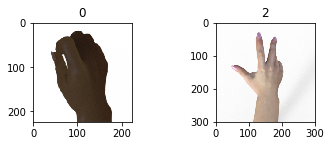

In [0]:
import matplotlib.pyplot as plt
import numpy as np


print(tf.executing_eagerly())
for n, image in enumerate(im_train.take(1)):
    plt.subplot(2, 2, 1)
    plt.imshow(image[0][0])
    plt.title(image[1][0].numpy())
for n, image in enumerate(im_train_un.take(1)):
    plt.subplot(2, 2, 2)
    plt.imshow(image[0])
    plt.title(image[1].numpy())

## Condition of Naval Propulsion Plants (Regression Dataset)

Goal is to predict the compressor decay state coefficient and the turbine decay state coefficient. Some subset of the two is also okay for preliminary tests

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import requests, zipfile, io, os
from sklearn.model_selection import train_test_split

columns = ['Lever position (lp) []', 'Ship speed (v) [knots]', 'Gas Turbine (GT) shaft torque (GTT) [kN m]', 
           'GT rate of revolutions (GTn) [rpm]', 'Gas Generator rate of revolutions (GGn) [rpm]',
           'Starboard Propeller Torque (Ts) [kN]', 'Port Propeller Torque (Tp) [kN]',
           'Hight Pressure (HP) Turbine exit temperature (T48) [C]', 'GT Compressor inlet air temperature (T1) [C]',
           'GT Compressor outlet air temperature (T2) [C]', 'HP Turbine exit pressure (P48) [bar]', 
           'GT Compressor inlet air pressure (P1) [bar]', 'GT Compressor outlet air pressure (P2) [bar]', 
           'GT exhaust gas pressure (Pexh) [bar]', 'Turbine Injecton Control (TIC) [%]', 'Fuel flow (mf) [kg/s]', 
           'GT Compressor decay state coefficient', 'GT Turbine decay state coefficient'] # outputs

path = r'https://archive.ics.uci.edu/ml/machine-learning-databases/00316/UCI CBM Dataset.zip'

r = requests.get(path)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
df = pd.read_fwf(r'UCI CBM Dataset/data.txt', names=columns)

scaler = MinMaxScaler()
scaler.fit(df)
df = scaler.transform(df)

x = df[:, :-2]
y = df[:, -2:]
y2 = df[:, -1]
# seperate tasks for a univariate and multivariate regression output
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x2, test_x2, train_y2, test_y2 = train_test_split(x, y2, test_size=0.2, random_state=17)

reg_mult_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(32).shuffle(1000)
reg_mult_test = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(32).shuffle(1000)
reg_mult_train = reg_mult_train.prefetch(tf.data.experimental.AUTOTUNE)

reg_uni_train = tf.data.Dataset.from_tensor_slices((train_x2, train_y2)).batch(32).shuffle(1000)
reg_uni_test = tf.data.Dataset.from_tensor_slices((test_x2, test_y2)).batch(32).shuffle(1000)
reg_uni_train = reg_uni_train.prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import requests, zipfile, io, os


columns = ['Lever position (lp) []', 'Ship speed (v) [knots]', 'Gas Turbine (GT) shaft torque (GTT) [kN m]', 
           'GT rate of revolutions (GTn) [rpm]', 'Gas Generator rate of revolutions (GGn) [rpm]',
           'Starboard Propeller Torque (Ts) [kN]', 'Port Propeller Torque (Tp) [kN]',
           'Hight Pressure (HP) Turbine exit temperature (T48) [C]', 'GT Compressor inlet air temperature (T1) [C]',
           'GT Compressor outlet air temperature (T2) [C]', 'HP Turbine exit pressure (P48) [bar]', 
           'GT Compressor inlet air pressure (P1) [bar]', 'GT Compressor outlet air pressure (P2) [bar]', 
           'GT exhaust gas pressure (Pexh) [bar]', 'Turbine Injecton Control (TIC) [%]', 'Fuel flow (mf) [kg/s]', 
           'GT Compressor decay state coefficient', 'GT Turbine decay state coefficient'] # outputs

path = r'https://archive.ics.uci.edu/ml/machine-learning-databases/00316/UCI CBM Dataset.zip'

r = requests.get(path)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
os.listdir()

['.config',
 'UCI CBM Dataset',
 '__MACOSX',
 'ngrok-stable-linux-amd64.zip',
 'ngrok',
 'sample_data']

In [0]:
df = pd.read_fwf(r'UCI CBM Dataset/data.txt', names=columns)
print(df.head())

   Lever position (lp) []  ...  GT Turbine decay state coefficient
0                   1.138  ...                               0.975
1                   2.088  ...                               0.975
2                   3.144  ...                               0.975
3                   4.161  ...                               0.975
4                   5.140  ...                               0.975

[5 rows x 18 columns]


In [0]:
scaler = MinMaxScaler()
scaler.fit(df)
df = scaler.transform(df)
print(pd.DataFrame(df).describe())

                 0             1   ...            16            17
count  11934.000000  11934.000000  ...  11934.000000  11934.000000
mean       0.493588      0.500000  ...      0.500000      0.500000
std        0.321782      0.322762  ...      0.294404      0.300013
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.245773      0.250000  ...      0.240000      0.240000
50%        0.490321      0.500000  ...      0.500000      0.500000
75%        0.736339      0.750000  ...      0.760000      0.760000
max        1.000000      1.000000  ...      1.000000      1.000000

[8 rows x 18 columns]


In [0]:
from sklearn.model_selection import train_test_split

# need to seperate for train and test set
x = df[:, :-2]
y = df[:, -2:]
y1 = df[:, -2]
y2 = df[:, -1]
print(x.shape, y.shape)
print(x.shape, y2.shape)
# seperate tasks for a univariate and multivariate regression output
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x2, test_x2, train_y2, test_y2 = train_test_split(x, y2, test_size=0.2, random_state=17)

(11934, 16) (11934, 2)
(11934, 16) (11934,)


In [0]:
reg_mult_train = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(32).shuffle(1000)
reg_mult_test = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(32).shuffle(1000)
reg_mult_train = reg_mult_train.prefetch(tf.data.experimental.AUTOTUNE)

reg_uni_train = tf.data.Dataset.from_tensor_slices((train_x2, train_y2)).batch(32).shuffle(1000)
reg_uni_test = tf.data.Dataset.from_tensor_slices((test_x2, test_y2)).batch(32).shuffle(1000)
reg_uni_train = reg_uni_train.prefetch(tf.data.experimental.AUTOTUNE)

## Census Dataset (Binary Classification income > $50,000)

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


columns = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital',
           'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
           'hours_week', 'native_country', 'label']
path = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
path_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

df = pd.read_csv(path, skipinitialspace = True, names = columns, index_col=False)
bin_test = pd.read_csv(path_test, skiprows=1, skipinitialspace = True, names = columns, index_col=False)

df = df.drop('education', axis=1)
bin_test = bin_test.drop('education', axis=1)
categoricals = ['workclass', 'marital', 'occupation', 'relationship', 'race', 'sex', 'native_country']

bin_train_labels = []
for i in range(len(df)):
    if df['label'][i] == '>50K':
        bin_train_labels.append(1)
    else:
        bin_train_labels.append(0)
bin_train_labels = np.array(bin_train_labels)

bin_test_labels = []
for i in range(len(bin_test)):
    if bin_test['label'][i] == '>50K.':
        bin_test_labels.append(1)
    else:
        bin_test_labels.append(0)
bin_test_labels = np.array(bin_test_labels)

df = pd.get_dummies(df.drop(['label'], axis=1), columns=categoricals)
bin_test = pd.get_dummies(bin_test.drop(['label'], axis=1), columns=categoricals)

if 'native_country_Holand-Netherlands' in bin_test.columns:
    bin_test = bin_test.drop(['native_country_Holand-Netherlands'], axis=1)
bin_test.insert(bin_test.columns.get_loc('native_country_Honduras'), 'native_country_Holand-Netherlands', value=0)

bin_train_x = np.array(df.values, dtype='float32')
bin_train_y = bin_train_labels
del bin_train_labels
bin_test_x = np.array(bin_test.values, dtype='float32')
bin_test_y = bin_test_labels
del bin_test_labels
scaler = MinMaxScaler()
scaler.fit(bin_train_x)
bin_train_x = scaler.transform(bin_train_x)
bin_test_x = scaler.transform(bin_test_x)
bin_train = tf.data.Dataset.from_tensor_slices((bin_train_x, bin_train_y)).batch(32).shuffle(1000)
bin_test = tf.data.Dataset.from_tensor_slices((bin_test_x, bin_test_y)).batch(32).shuffle(1000)
bin_train = bin_train.prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


columns = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital',
           'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
           'hours_week', 'native_country', 'label']
path = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
path_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
df = pd.read_csv(path, skipinitialspace = True, names = columns, index_col=False)
bin_test = pd.read_csv(path_test, skiprows=1, skipinitialspace = True, names = columns, index_col=False)
df = df.drop('education', axis=1)
bin_test = bin_test.drop('education', axis=1)
categoricals = ['workclass', 'marital', 'occupation', 'relationship', 'race', 'sex', 'native_country']

In [0]:
print(df.head())
print(bin_test.head())

   age         workclass  fnlwgt  ...  hours_week native_country  label
0   39         State-gov   77516  ...          40  United-States  <=50K
1   50  Self-emp-not-inc   83311  ...          13  United-States  <=50K
2   38           Private  215646  ...          40  United-States  <=50K
3   53           Private  234721  ...          40  United-States  <=50K
4   28           Private  338409  ...          40           Cuba  <=50K

[5 rows x 14 columns]
   age  workclass  fnlwgt  ...  hours_week native_country   label
0   25    Private  226802  ...          40  United-States  <=50K.
1   38    Private   89814  ...          50  United-States  <=50K.
2   28  Local-gov  336951  ...          40  United-States   >50K.
3   44    Private  160323  ...          40  United-States   >50K.
4   18          ?  103497  ...          30  United-States  <=50K.

[5 rows x 14 columns]


In [0]:
bin_train_labels = []

for i in range(len(df)):
    if df['label'][i] == '>50K':
        bin_train_labels.append(1)
    else:
        bin_train_labels.append(0)
        
bin_train_labels = np.array(bin_train_labels)
print(bin_train_labels[:15], len(bin_train_labels))

bin_test_labels = []
for i in range(len(bin_test)):
    if bin_test['label'][i] == '>50K.':
        bin_test_labels.append(1)
    else:
        bin_test_labels.append(0)
        
bin_test_labels = np.array(bin_test_labels)
print(bin_test_labels[:15], len(bin_test_labels))

[0 0 0 0 0 0 0 1 1 1 1 1 0 0 1] 32561
[0 0 1 1 0 0 0 1 0 0 1 0 0 0 1] 16281


In [0]:
df = pd.get_dummies(df.drop(['label'], axis=1), columns=categoricals)
bin_test = pd.get_dummies(bin_test.drop(['label'], axis=1), columns=categoricals)

In [0]:
if 'native_country_Holand-Netherlands' in bin_test.columns:
    bin_test = bin_test.drop(['native_country_Holand-Netherlands'], axis=1)
bin_test.insert(bin_test.columns.get_loc('native_country_Honduras'), 'native_country_Holand-Netherlands', value=0)
print(df.describe())
print(bin_test.describe())

                age  ...  native_country_Yugoslavia
count  32561.000000  ...               32561.000000
mean      38.581647  ...                   0.000491
std       13.640433  ...                   0.022162
min       17.000000  ...                   0.000000
25%       28.000000  ...                   0.000000
50%       37.000000  ...                   0.000000
75%       48.000000  ...                   0.000000
max       90.000000  ...                   1.000000

[8 rows x 92 columns]
                age  ...  native_country_Yugoslavia
count  16281.000000  ...               16281.000000
mean      38.767459  ...                   0.000430
std       13.849187  ...                   0.020731
min       17.000000  ...                   0.000000
25%       28.000000  ...                   0.000000
50%       37.000000  ...                   0.000000
75%       48.000000  ...                   0.000000
max       90.000000  ...                   1.000000

[8 rows x 92 columns]


In [0]:
bin_train_x = np.array(df.values, dtype='float32')
bin_train_y = bin_train_labels
del bin_train_labels
bin_test_x = np.array(bin_test.values, dtype='float32')
bin_test_y = bin_test_labels
del bin_test_labels

In [0]:
print(bin_train_x[7], bin_train_y[7])

[5.20000e+01 2.09642e+05 9.00000e+00 0.00000e+00 0.00000e+00 4.50000e+01
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.

In [0]:
print(bin_train_x.shape)

(32561, 92)


In [0]:
scaler = MinMaxScaler()
scaler.fit(bin_train_x)
bin_train_x = scaler.transform(bin_train_x)
bin_test_x = scaler.transform(bin_test_x)

In [0]:
bin_train = tf.data.Dataset.from_tensor_slices((bin_train_x, bin_train_y)).batch(32).shuffle(1000)
bin_test = tf.data.Dataset.from_tensor_slices((bin_test_x, bin_test_y)).batch(32).shuffle(1000)
bin_train = bin_train.prefetch(tf.data.experimental.AUTOTUNE)

## Fashion MNIST (Sparse Categorical Classification)

In [0]:
dataset, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True)
class_train, class_test = dataset['train'], dataset['test']

def scaling(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

class_train = class_train.map(scaling).shuffle(10000).batch(64)
class_test = class_test.map(scaling).batch(64)
class_train = class_train.prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
dataset, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True)
class_train, class_test = dataset['train'], dataset['test']

In [0]:
print(info)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=1.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)
    },
    total_num_examples=70000,
    splits={
        'test': <tfds.core.SplitInfo num_examples=10000>,
        'train': <tfds.core.SplitInfo num_examples=60000>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @article{DBLP:journals/corr/abs-1708-07747,
          author    = {Han Xiao and
                       Kashif Rasul and
                       Roland Vollgraf},
          title     = {Fashion-MNIST: a Novel Image Dataset for Benchmark

In [0]:
def scaling(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

In [0]:
class_train = class_train.map(scaling).shuffle(10000).batch(64)
class_test = class_test.map(scaling).batch(64)

In [0]:
class_train.output_shapes

(TensorShape([None, 28, 28, 1]), TensorShape([None]))

In [0]:
class_train = class_train.prefetch(tf.data.experimental.AUTOTUNE)

## TF.Data

In [0]:
x = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(x)
# chaining transformations
dataset = dataset.repeat(3).batch(7, drop_remainder=True)
dataset = dataset.map(lambda x: x**2, num_parallel_calls = tf.data.experimental.AUTOTUNE) # uses all available processors
for item in dataset:
    print(item)


tf.Tensor([ 0  1  4  9 16 25 36], shape=(7,), dtype=int32)
tf.Tensor([49 64 81  0  1  4  9], shape=(7,), dtype=int32)
tf.Tensor([16 25 36 49 64 81  0], shape=(7,), dtype=int32)
tf.Tensor([ 1  4  9 16 25 36 49], shape=(7,), dtype=int32)


In [0]:
# while map works on each item, apply works on the whole dataset
dataset = dataset.unbatch()

# filter the dataset with filter()
dataset = dataset.filter(lambda x: x < 50)
print([item for item in dataset.take(3)])

[<tf.Tensor: id=211562, shape=(), dtype=int32, numpy=0>, <tf.Tensor: id=211563, shape=(), dtype=int32, numpy=1>, <tf.Tensor: id=211564, shape=(), dtype=int32, numpy=4>]


In [0]:
# shuffling is critical to well performing networks because it requires data to be i.i.d.
dataset = tf.data.Dataset.range(10)
dataset = dataset.shuffle(buffer_size = 10, seed=42).repeat(3).batch(7)
for item in dataset:
    print(item)

W0624 17:45:11.408681 140673620375424 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


tf.Tensor([2 0 7 8 9 3 6], shape=(7,), dtype=int64)
tf.Tensor([4 1 5 6 1 3 7], shape=(7,), dtype=int64)
tf.Tensor([9 2 5 4 8 0 8], shape=(7,), dtype=int64)
tf.Tensor([0 6 5 1 4 9 7], shape=(7,), dtype=int64)
tf.Tensor([3 2], shape=(2,), dtype=int64)


Now consider the problem of not being able to load all of the data into memory. Buffering and shuffling would not work well since only a small amount of the data would be represented by the buffer. Shuffling from the source could work but it still has the same order then and would need to be buffer shuffled as well still. One way this is done is by splitting the main data into many files which are shuffled, then a random set of the files are pulled into the buffer and shuffled. TF has good methods for this, consider the California housing dataset split into training, validation and test as well as split into CSV files with 8 input features plus the label.

### California Housing Dataset

In [0]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
x_train, x_test, y_train, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)

scaler = StandardScaler()
scaler.fit(x_train)
x_mean = scaler.mean_
x_std = scaler.scale_

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=42)

I0624 17:45:11.480339 140673620375424 california_housing.py:114] Downloading Cal. housing from https://ndownloader.figshare.com/files/5976036 to /root/scikit_learn_data


In [0]:
def save_to_mult_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_ {}_{:02d}.csv")
    
    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
                
    return filepaths

In [0]:
train = np.c_[x_train, y_train]
valid = np.c_[x_valid, y_valid]
test = np.c_[x_test, y_test]

headers = housing.feature_names + ["MedianHouseVal"]
header = ",".join(headers)

train_fps = save_to_mult_csv_files(train, "train", header, n_parts=20)
valid_fps = save_to_mult_csv_files(valid, "valid", header, n_parts=10)
test_fps = save_to_mult_csv_files(test, "test", header, n_parts=10)


In [0]:
'''
MedInc, HouseAge, AveRooms, AveBedrms,  Popul,   AveOccup,  Lat,    Long,    MedianHouseValue
3.5214, 15.0,     3.0499,   1.1065,     1447.0,  1.6059,    37.63,  -122.43, 1.442
5.3275, 5.0,      6.4900,   0.9910,     3464.0,  3.4433,    33.69,  -117.39, 11.687
[...]
'''


filepath_dataset = tf.data.Dataset.list_files(train_fps, seed=43) # returns a shuffled list


# setup an interleaving with 5 files skipping the first line (column names)

n_readers = 5
dataset = filepath_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers, num_parallel_calls=tf.data.experimental.AUTOTUNE)

This works best for same length files because the interleaving goes through all files until all lines run out. Then it grabs the next 5 files and does the same, going one line at a time for each file before going to the next line. It also returns data as byte strings, which need parsing and scaling

In [0]:
# assume x_mean, x_std are known for each of the 8 features
n_inputs=8

# set default values of 0 for any missing features, and None for missing labels to raise a warning if missing
def preprocess(line):
    defaults = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defaults)
    x = tf.stack(fields[:-1]) # stack the list of tensors into a 1D array
    y = tf.stack(fields[-1:])
    return (x - x_mean) / x_std, y

In [0]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5, 
                      n_read_threads=tf.data.experimental.AUTOTUNE, shuffle_buffer_size=100000,
                      n_parse_threads=tf.data.experimental.AUTOTUNE, batch_size=32):
    
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
                                 cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    
    return dataset.prefetch(3) # always fetch 3 batches ahead

# other methods include concatenate(), zip(), window(), reduce(), cache(), shard(), flat_map(), and padded_batch()

In [0]:
# if a custom training method is needed then simply iterate over the dataset
model = tf.keras.models.Sequential([keras.layers.Dense(30, activation='relu') for _ in range(5)])
model.add(keras.layers.Dense(1))

optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
epochs = 5
batch_size=32
n_steps_per_epoch = len(x_train) // batch_size
total_steps = epochs * n_steps_per_epoch

@tf.function
def train(model, optimizer, loss_fn, n_epochs):
    global_step = 0
    train_set = csv_reader_dataset(train_fps, repeat=n_epochs, batch_size = batch_size)
    for x_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)

        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
train(model, optimizer, loss_fn, epochs)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


## Feature Columns

In [0]:
trainset = csv_reader_dataset(train_fps)
housing_med_age = tf.feature_column.numeric_column("housing_median_age", normalizer_fn = lambda x: (x - x_mean[1]) / x_std[1])

It can be beneficial to bucketize numeric features, basically turning the value into a categorical one. This can help reduce complexity, especially if the values make more sense as a range with similar outputs. 

In [0]:
# transform the median_income into 5 buckets: <1.5, 1.5-3, 3-4.5, 4.5-6, 6<
median_income = tf.feature_column.numeric_column("med_income")
bucketized_income = tf.feature_column.bucketized_column(median_income, boundaries=[1.5, 3., 4.5, 6.])
# determining the ideal boundaries requires analyzing the data in advance. 
# Can try percentiles or multimodal distributions

In [0]:
# for categorical features, if it is already numeric then use cateogrical_column_with_identity(max id value)
# otherwise you must use categorical_column_with_vocabulary_list()

ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list("ocean_proximity", ocean_prox_vocab)

# for very large vocabularies like zipcodes or cities it may be more useful to use categorical_column_with_hash_bucket()

# city_hash = tf.feature_column.categorical_column_with_hash_bucket("city", hash_bucket_size=1000)

# This will create a hash for each city modulo the number of hash buckets. If the buckets are too low there is overlap,
# but if they are too high it will take more RAM to make the embedding table

Sometimes feature make more sense crossed, for example old houses inland or new houses by the ocean. This can be done with a similar bucketizing method as before

In [0]:
bucketized_age = tf.feature_column.bucketized_column(housing_med_age, boundaries = [-1., -0.5, 0., 0.5, 1.]) # scaled values
age_ocean_prox = tf.feature_column.crossed_column([bucketized_age, ocean_proximity], hash_bucket_size = 100)

# often times this is good for crossing longitude and latitude as a grid
latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")
bucket_lat = tf.feature_column.bucketized_column(latitude, boundaries=list(np.linspace(32., 42., 20-1)))
bucket_long = tf.feature_column.bucketized_column(longitude, boundaries=list(np.linspace(-125., -114., 20-1)))
location = tf.feature_column.crossed_column([bucket_lat, bucket_long], hash_bucket_size=1000)

The choice then becomes whether to do 1 hot encoding or dense embeddings. For some there are too many values for 1 hot encoding to make sense, while dense embeddings can seem to bleed over if the NN is not wide/deep enough. If you use a hash bucket, you will likely need embeddings because many possible outputs are generated. Embeddings also usually require more training data, so for less than 10-50 categories, one hot is the way to go.

In [0]:
# one hot encoding is easy
ocean_prox_one_hot = tf.feature_column.indicator_column(ocean_proximity)

the use of embeddings is trainable, so it is often called representation learning and is useful for analyizing categories. It was also found that word embeddings can be used with astounding relation to the axis present. For example, taking King (minus) Man + Woman the result is very close to Queen. So the embeddings can encode incredible amounts of information like gender and more!


In [0]:
# embedding the ocean_proximity as a 2D embedding
ocean_prox_embed = tf.feature_column.embedding_column(ocean_proximity, dimension=2)

Another good option is if there is not enough data or pretrained embeddings for use, then training on an auxiliary task has been shown to work very well. For example in language translation, start by training on two languages with translations that are known, or train with one of the languages known but on a different task than translation.

In [0]:
# To use Feature Columns add a keras.layers.DenseFeatures() in
columns_without_target = [ocean_prox_embed, tf.feature_column.embedding_column(location, dimension=5)] # add more
model = keras.models.Sequential([keras.layers.DenseFeatures(feature_columns = columns_without_target),
                                 keras.layers.Dense(100, activation='relu'),
                                 keras.layers.Dense(1)
                                ])
model.compile(loss='mse', optimizer='nadam', metrics=['accuracy'])
steps = len(x_train) // 32
#history = model.fit(trainset, steps_per_epoch=steps, epochs=5)

The major flaw with this technique is that it preprocesses on the fly, rather than handling it in advance. For a real time application this may be required, but it is likely to slow the model down significantly. Instead using transformations, this can be handled.

## TF Extended

Tensorflow Extended is an end to end platform for productionizing models. These methods do not come installed in tensorflow but they can be downloaded and used. Then all of the preprocessing can be written using TF Transform functions/TF functions.

In [0]:
#!pip install tensorflow_transform
#import tensorflow_transform as tft

In [0]:
# if tf transform works then the following can be used to nicely handle preprocessing

# def preprocess(inputs):
#     median_age = inputs["housing_med_age"]
#     ocean_prox = inputs["ocean_prox"]
#     standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
#     ocean_prox_id = tft.compute_and_apply_vocabulary(ocean_prox)
#     return {"standardized_med_age" : standardized_age,
#             "ocean_prox_id" : ocean_prox_id}

## TFRecords

Very useful for more complex or large data structures like images and audio

In [0]:
# read and write data, but it must be binary!
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"first record")
    f.write(b"second record")
    f.close()
    
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=4) # will interleave in parallel
for item in dataset:
    print(item)

tf.Tensor(b'first record', shape=(), dtype=string)
tf.Tensor(b'second record', shape=(), dtype=string)


In [0]:
# compress a TFRecord file
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    for i in tf.range(100):
        f.write(b"This is a long compressed file which should be fine")
    f.close()
    
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"], compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(b'This is a long compressed file which should be fine', shape=(), dtype=string)
tf.Tensor(

# NN

## Sequential, simple model

In [0]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [0]:
# define loss and optimizer
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Nadam()
model1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
#Setup callbacks
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint = keras.callbacks.ModelCheckpoint('basic_3_layer.h5', save_best_only = True)
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights = True)

class ValTrainRatio(keras.callbacks.Callback):
    #custom callback, can occur on many instances see https://keras.io/callbacks/
    def on_epoch_end(self, epoch, logs):
        print("\n val/train : {:.2f}".format(logs['val_loss'] / logs['loss']))
        
ratio = ValTrainRatio()


history = model1.fit(class_train, epochs=25, validation_data=class_test, callbacks=[tensorboard_cb, checkpoint, early_stopping, ratio])

Epoch 1/25
    938/Unknown - 18s 19ms/step - loss: 0.4763 - accuracy: 0.8296
 val/train : 0.80
938/938 [==============================] - 20s 22ms/step - loss: 0.4763 - accuracy: 0.8296 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
929/938 [============================>.] - ETA: 0s - loss: 0.3459 - accuracy: 0.8741
 val/train : 1.13
938/938 [==============================] - 17s 18ms/step - loss: 0.3460 - accuracy: 0.8740 - val_loss: 0.3916 - val_accuracy: 0.8546
Epoch 3/25
936/938 [============================>.] - ETA: 0s - loss: 0.3084 - accuracy: 0.8860
 val/train : 1.20
938/938 [==============================] - 17s 18ms/step - loss: 0.3084 - accuracy: 0.8860 - val_loss: 0.3690 - val_accuracy: 0.8650
Epoch 4/25
937/938 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.8940
 val/train : 1.18
938/938 [==============================] - 17s 18ms/step - loss: 0.2848 - accuracy: 0.8940 - val_loss: 0.3370 - val_accuracy: 0.8771
Epoch 5/25
928/938 [===

In [0]:
print(model1.weights[0])
model1.save('basic_3_layer.h5')

<tf.Variable 'dense_8/kernel:0' shape=(784, 300) dtype=float32, numpy=
array([[ 0.03711117,  0.05765176,  0.15257393, ...,  0.08886811,
         0.02836593, -0.25265685],
       [ 0.03352015,  0.16572288,  0.18764025, ...,  0.02099244,
        -0.1923602 ,  0.06586257],
       [ 0.21845663,  0.07587048,  0.05681629, ...,  0.07246236,
        -0.14306712, -0.10494175],
       ...,
       [ 0.24243185,  0.02188442, -0.04994349, ..., -0.14348918,
        -0.02029968,  0.11790403],
       [ 0.1450852 , -0.06028718, -0.00325868, ..., -0.00838439,
         0.07034486, -0.08494765],
       [ 0.1596245 ,  0.06205353,  0.13057427, ..., -0.00494469,
        -0.00526665,  0.04955888]], dtype=float32)>


In [0]:
model1 = keras.models.load_model('basic_3_layer.h5')
print(model1.weights[0])

<tf.Variable 'dense_8_1/kernel:0' shape=(784, 300) dtype=float32, numpy=
array([[ 0.03711117,  0.05765176,  0.15257393, ...,  0.08886811,
         0.02836593, -0.25265685],
       [ 0.03352015,  0.16572288,  0.18764025, ...,  0.02099244,
        -0.1923602 ,  0.06586257],
       [ 0.21845663,  0.07587048,  0.05681629, ...,  0.07246236,
        -0.14306712, -0.10494175],
       ...,
       [ 0.24243185,  0.02188442, -0.04994349, ..., -0.14348918,
        -0.02029968,  0.11790403],
       [ 0.1450852 , -0.06028718, -0.00325868, ..., -0.00838439,
         0.07034486, -0.08494765],
       [ 0.1596245 ,  0.06205353,  0.13057427, ..., -0.00494469,
        -0.00526665,  0.04955888]], dtype=float32)>


## Subclassing 

In [0]:
class trimodel(keras.models.Model):
    def __init__(self, units=300, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.f1 = keras.layers.Flatten(input_shape=[28, 28, 1])
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units//3, activation=activation)
        self.output1 = keras.layers.Dense(10, activation='softmax')
        
        self.f2 = keras.layers.Flatten(input_shape=[28, 28, 1])
        self.h1 = keras.layers.Dense(units, activation=activation)
        self.h2 = keras.layers.Dense(units//3, activation=activation)
        self.h3 = keras.layers.Dense(units//3, activation = activation)
        self.output2 = keras.layers.Dense(10, activation='softmax')
        
        self.conv1 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=[28, 28, 1])
        self.conv2 = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.f3 = keras.layers.Flatten()
        self.output3 = keras.layers.Dense(10, activation='softmax')
        
    def call(self, image):
        x = self.f1(image)
        x = self.hidden1(x)
        x = self.hidden2(x)
        output1 = self.output1(x)
        
        inputs = self.f2(image)
        y = self.h1(inputs)
        inter = self.h2(y)
        inter2 = self.h3(inputs)
        output2 = self.output2(inter+inter2)
        
        z = self.conv1(image)
        z = self.conv2(z)
        z = self.f3(z)
        output3 = self.output3(z)
        
        return (output1+output2+output3)/3.0
    
model = trimodel()

### Selective eager training

In [0]:
# set up loss tracking
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')

In [0]:
# train the model
@tf.function
def train_step(image, label):
  with tf.GradientTape() as tape:
    predictions = model(image)
    loss = loss_func(label, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  train_loss(loss)
  train_acc(label, predictions)

In [0]:
# testing the model
@tf.function
def test_step(image, label):
  predictions = model(image)
  t_loss = loss_func(label, predictions)
  
  test_loss(t_loss)
  test_acc(label, predictions)

In [0]:
epochs = 5

for epoch in range(epochs):
  for image, label in class_train:
    train_step(image, label)
    
  for image, label in class_test:
    test_step(image, label)
    
  printing = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
  print(printing.format(epoch+1, train_loss.result(), train_acc.result()*100, test_loss.result(), test_acc.result()*100))

Epoch 1, Loss: 0.6263570785522461, Acc: 83.78833770751953, Test Loss: 0.559393584728241, Test Acc: 86.94000244140625
Epoch 2, Loss: 0.5709589719772339, Acc: 86.38166809082031, Test Loss: 0.5427657961845398, Test Acc: 87.87999725341797
Epoch 3, Loss: 0.5357652306556702, Acc: 87.65611267089844, Test Loss: 0.5290954113006592, Test Acc: 87.92666625976562
Epoch 4, Loss: 0.5099745988845825, Acc: 88.538330078125, Test Loss: 0.5169247984886169, Test Acc: 88.3949966430664
Epoch 5, Loss: 0.48107072710990906, Acc: 89.15567016601562, Test Loss: 0.4865955412387848, Test Acc: 88.54199981689453


###Keras Fit training

In [0]:
#Setup callbacks
model = trimodel()
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
#checkpoint = keras.callbacks.ModelCheckpoint('basic_3_layer.h5', save_best_only = True)
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights = True)

class ValTrainRatio(keras.callbacks.Callback):
    #custom callback, can occur on many instances see https://keras.io/callbacks/
    def on_epoch_end(self, epoch, logs):
        print("\n val/train : {:.2f}".format(logs['val_loss'] / logs['loss']))
        
ratio = ValTrainRatio()


history = model.fit(class_train, epochs=25, validation_data=class_test, callbacks=[tensorboard_cb, early_stopping, ratio])

Epoch 1/25
    938/Unknown - 24s 25ms/step - loss: 0.5228 - accuracy: 0.7426
 val/train : 0.82
938/938 [==============================] - 26s 28ms/step - loss: 0.5228 - accuracy: 0.7426 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
933/938 [============================>.] - ETA: 0s - loss: 0.3419 - accuracy: 0.8720
 val/train : 1.04
938/938 [==============================] - 20s 21ms/step - loss: 0.3416 - accuracy: 0.8720 - val_loss: 0.3549 - val_accuracy: 0.8785
Epoch 3/25
936/938 [============================>.] - ETA: 0s - loss: 0.2895 - accuracy: 0.8945
 val/train : 1.14
938/938 [==============================] - 20s 22ms/step - loss: 0.2899 - accuracy: 0.8945 - val_loss: 0.3294 - val_accuracy: 0.8794
Epoch 4/25
933/938 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.9035
 val/train : 1.23
938/938 [==============================] - 21s 22ms/step - loss: 0.2526 - accuracy: 0.9035 - val_loss: 0.3106 - val_accuracy: 0.8786
Epoch 5/25
935/938 [===

In [0]:
print(model.weights[0])
model.save_weights('trimodel_weights.hdf5')

<tf.Variable 'trimodel_1/dense_19/kernel:0' shape=(784, 300) dtype=float32, numpy=
array([[-0.03012997,  0.04244632, -0.05340557, ...,  0.08421898,
         0.07002327,  0.12829384],
       [ 0.19203302, -0.1921227 ,  0.07973646, ...,  0.00913971,
         0.13027734, -0.01388968],
       [-0.0956382 ,  0.05820296,  0.00970269, ..., -0.09593527,
        -0.09161424,  0.14986284],
       ...,
       [-0.0243759 ,  0.00180845, -0.07871275, ...,  0.0058651 ,
        -0.05926486,  0.24599852],
       [-0.04491796,  0.08778168,  0.01592516, ...,  0.01437294,
        -0.1444625 ,  0.31743369],
       [ 0.07609524,  0.18678845, -0.07029418, ..., -0.06623689,
        -0.11591122,  0.18712434]], dtype=float32)>


In [0]:
print(len(model.layers))
model.load_weights('trimodel_weights.hdf5')
print(model.weights[0])

13
<tf.Variable 'trimodel_1/dense_19/kernel:0' shape=(784, 300) dtype=float32, numpy=
array([[-0.03012997,  0.04244632, -0.05340557, ...,  0.08421898,
         0.07002327,  0.12829384],
       [ 0.19203302, -0.1921227 ,  0.07973646, ...,  0.00913971,
         0.13027734, -0.01388968],
       [-0.0956382 ,  0.05820296,  0.00970269, ..., -0.09593527,
        -0.09161424,  0.14986284],
       ...,
       [-0.0243759 ,  0.00180845, -0.07871275, ...,  0.0058651 ,
        -0.05926486,  0.24599852],
       [-0.04491796,  0.08778168,  0.01592516, ...,  0.01437294,
        -0.1444625 ,  0.31743369],
       [ 0.07609524,  0.18678845, -0.07029418, ..., -0.06623689,
        -0.11591122,  0.18712434]], dtype=float32)>


## Parameter Tuning

Need to implement a method which searches for the optimal hyperparameters rather than testing over and over. One method is to use the grid search available through sklearn. To do this a wrapper is needed to take the keras model to sklearn. This can be done with the built in wrapper, especially for simple models like the first one.

In [0]:
# wrapper requires a build function
def build_model(n_hidden = 1, n_neurons = 300, learning_rate=1e-3, input_shape=[28, 28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons//(layer+1), activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [0]:
keras_classifier = keras.wrappers.scikit_learn.KerasClassifier(build_model)

Must have non-dataset style data to use sklearns features. Using the built in fashion mnist

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, y_train.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)


In [0]:
x_train, x_test = x_train/255.0, x_test/255.0
print(x_train.shape)

(60000, 28, 28)


In [0]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

params = {'n_hidden': [2, 3, 4, 5],
         'n_neurons': np.arange(10, 300),
          'learning_rate': reciprocal(1e-3, 3e-2),
         }

In [0]:
rnd_search = RandomizedSearchCV(keras_classifier, params, n_iter=5, cv=3)
rnd_search.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)])

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 5s 132us/sample - loss: 0.5378 - accuracy: 0.8062 - val_loss: 0.4756 - val_accuracy: 0.8301
Epoch 2/50
40000/40000 [==============================] - 5s 126us/sample - loss: 0.4012 - accuracy: 0.8550 - val_loss: 0.4233 - val_accuracy: 0.8492
Epoch 3/50
40000/40000 [==============================] - 5s 125us/sample - loss: 0.3659 - accuracy: 0.8651 - val_loss: 0.4440 - val_accuracy: 0.8457
Epoch 4/50
40000/40000 [==============================] - 5s 125us/sample - loss: 0.3408 - accuracy: 0.8743 - val_loss: 0.3840 - val_accuracy: 0.8620
Epoch 5/50
40000/40000 [==============================] - 5s 126us/sample - loss: 0.3242 - accuracy: 0.8810 - val_loss: 0.3696 - val_accuracy: 0.8684
Epoch 6/50
40000/40000 [==============================] - 5s 126us/sample - loss: 0.3085 - accuracy: 0.8863 - val_loss: 0.3523 - val_accuracy: 0.8744
Epoch 7/50
40000/40000 [==========================

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7ff010a46940>,
                   iid='warn', n_iter=5, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff010a46e48>,
                                        'n_hidden': [2, 3, 4, 5],
                                        'n_neurons': array([ 10,  11,  12,  13,  14,  15,  16,...
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 297, 298, 299])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
           

In [0]:
print(rnd_search.best_params_)
print(rnd_search.best_score_)
model3 = rnd_search.best_estimator_.model

{'learning_rate': 0.0017649040129441521, 'n_hidden': 4, 'n_neurons': 207}
0.8805833458900452


## Weight Initialization

Often times weight initialization is not used, however it can have a huge effect on convergence and vanishing/exploding gradients. This goes through some important initializations for various activation functions. 

Table 11-1 states that for activation functions the recommendation is as follows:
**Glorot** -> None, Tanh, Logistic, Softmax -> $\sigma^2 = \frac{1}{fan_{avg}}$
**He** -> ReLU & Variants -> $\sigma^2 = \frac{2}{fan_{in}}$
**LeCun** -> SELU -> $\sigma^2 = \frac{1}{fan_{in}}$


Keras defaults to Glorot initialization but it can be changed as the following models will show

SELU is a scaled exponential linear unit which performs great because it self normalizes if: 
Input features are standardized to mean 0 and std 1, every hidden layers weights are initialized using LeCun normal (kernel_initializer = 'lecun_normal'), Sequential architecture, and all layers are dense although practice shows it works for cnn as well.

In [0]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation = 'softmax')
])

model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')
])

leaky_relu = keras.layers.LeakyReLU(alpha=0.2)
model3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers. Dense(100, activation=leaky_relu, kernel_initializer='he_normal'),
    keras.layers.Dense(100, activation=leaky_relu, kernel_initializer='he_normal'),
    keras.layers.Dense(100, activation=leaky_relu, kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation = 'softmax', kernel_initializer='glorot_normal')
])

model4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(10, activation = 'softmax', kernel_initializer='glorot_normal')
])

In [0]:
optimizer = keras.optimizers.Adam(6e-3)
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights = True)

class ValTrainRatio(keras.callbacks.Callback):
    #custom callback, can occur on many instances see https://keras.io/callbacks/
    def on_epoch_end(self, epoch, logs):
        print("\n val/train : {:.2f}".format(logs['val_loss'] / logs['loss']))
        
ratio = ValTrainRatio()


history1 = model1.fit(class_train, epochs=25, validation_data=class_test, callbacks=[tensorboard_cb, early_stopping, ratio])

Epoch 1/25
    938/Unknown - 16s 17ms/step - loss: 0.5178 - accuracy: 0.8166
 val/train : 0.87
938/938 [==============================] - 18s 19ms/step - loss: 0.5178 - accuracy: 0.8166 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
932/938 [============================>.] - ETA: 0s - loss: 0.3738 - accuracy: 0.8639
 val/train : 1.03
938/938 [==============================] - 15s 16ms/step - loss: 0.3735 - accuracy: 0.8640 - val_loss: 0.3835 - val_accuracy: 0.8641
Epoch 3/25
931/938 [============================>.] - ETA: 0s - loss: 0.3348 - accuracy: 0.8770
 val/train : 1.09
938/938 [==============================] - 15s 16ms/step - loss: 0.3351 - accuracy: 0.8769 - val_loss: 0.3661 - val_accuracy: 0.8659
Epoch 4/25
925/938 [============================>.] - ETA: 0s - loss: 0.3115 - accuracy: 0.8853
 val/train : 1.14
938/938 [==============================] - 15s 16ms/step - loss: 0.3114 - accuracy: 0.8852 - val_loss: 0.3542 - val_accuracy: 0.8709
Epoch 5/25
934/938 [===

In [0]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history2 = model2.fit(class_train, epochs=25, validation_data=class_test, callbacks=[tensorboard_cb, early_stopping, ratio])

Epoch 1/25
    938/Unknown - 16s 17ms/step - loss: 0.5133 - accuracy: 0.8177
 val/train : 0.81
938/938 [==============================] - 18s 19ms/step - loss: 0.5133 - accuracy: 0.8177 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
926/938 [============================>.] - ETA: 0s - loss: 0.3727 - accuracy: 0.8651
 val/train : 1.07
938/938 [==============================] - 15s 16ms/step - loss: 0.3731 - accuracy: 0.8649 - val_loss: 0.4001 - val_accuracy: 0.8533
Epoch 3/25
937/938 [============================>.] - ETA: 0s - loss: 0.3369 - accuracy: 0.8761
 val/train : 1.13
938/938 [==============================] - 15s 16ms/step - loss: 0.3368 - accuracy: 0.8761 - val_loss: 0.3804 - val_accuracy: 0.8648
Epoch 4/25
936/938 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8836
 val/train : 1.15
938/938 [==============================] - 15s 16ms/step - loss: 0.3153 - accuracy: 0.8836 - val_loss: 0.3622 - val_accuracy: 0.8691
Epoch 5/25
935/938 [===

In [0]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history3 = model3.fit(class_train, epochs=25, validation_data=class_test, callbacks=[tensorboard_cb, early_stopping, ratio])

W0624 18:18:09.977838 140673620375424 summary_ops_v2.py:1110] Model failed to serialize as JSON. Ignoring... 'LeakyReLU' object has no attribute '__name__'


Epoch 1/25
    938/Unknown - 15s 17ms/step - loss: 0.4999 - accuracy: 0.8199
 val/train : 0.84
938/938 [==============================] - 17s 19ms/step - loss: 0.4999 - accuracy: 0.8199 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
931/938 [============================>.] - ETA: 0s - loss: 0.3778 - accuracy: 0.8613
 val/train : 1.03
938/938 [==============================] - 15s 16ms/step - loss: 0.3781 - accuracy: 0.8613 - val_loss: 0.3893 - val_accuracy: 0.8581
Epoch 3/25
933/938 [============================>.] - ETA: 0s - loss: 0.3408 - accuracy: 0.8758
 val/train : 1.07
938/938 [==============================] - 15s 16ms/step - loss: 0.3407 - accuracy: 0.8758 - val_loss: 0.3656 - val_accuracy: 0.8673
Epoch 4/25
930/938 [============================>.] - ETA: 0s - loss: 0.3211 - accuracy: 0.8815
 val/train : 1.13
938/938 [==============================] - 15s 16ms/step - loss: 0.3210 - accuracy: 0.8815 - val_loss: 0.3632 - val_accuracy: 0.8691
Epoch 5/25
935/938 [===

In [0]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history4 = model4.fit(class_train, epochs=25, validation_data=class_test, callbacks=[tensorboard_cb, early_stopping, ratio])

Epoch 1/25
    938/Unknown - 16s 17ms/step - loss: 0.4975 - accuracy: 0.8193
 val/train : 0.89
938/938 [==============================] - 18s 19ms/step - loss: 0.4975 - accuracy: 0.8193 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
928/938 [============================>.] - ETA: 0s - loss: 0.3875 - accuracy: 0.8578
 val/train : 1.04
938/938 [==============================] - 15s 16ms/step - loss: 0.3872 - accuracy: 0.8579 - val_loss: 0.4013 - val_accuracy: 0.8539
Epoch 3/25
932/938 [============================>.] - ETA: 0s - loss: 0.3489 - accuracy: 0.8718
 val/train : 1.11
938/938 [==============================] - 15s 16ms/step - loss: 0.3495 - accuracy: 0.8716 - val_loss: 0.3870 - val_accuracy: 0.8611
Epoch 4/25
937/938 [============================>.] - ETA: 0s - loss: 0.3315 - accuracy: 0.8776
 val/train : 1.14
938/938 [==============================] - 15s 16ms/step - loss: 0.3317 - accuracy: 0.8776 - val_loss: 0.3782 - val_accuracy: 0.8658
Epoch 5/25
931/938 [===

The results suggest that the uninitialized network performed the best... This is very strange and I cannot comment on why. The information in the book suggests this should not be the case but it may be a result of network architecture somehow. The recommendations from the book are in the next comment

Ideal activation functions go SELU > ELU > LeakyReLU > ReLU > tanh > Logistic. If the architecture cannot self normalize then ELU may beat SELU. If runtime latency matters use leakyReLU. Other variants include RReLU if the network overfits or PReLU if a large dataset is available.

## Batch normalization

Batch normalization works by scaling and shifting the values from a network, either before or after the activation layer. The key notes are that it works incredibly well to remove vanishing/exploding gradients. This allows for much higher learning rates, such that in models used on ImageNet it was able to reduce training time by 14x. It does however, add some complexity, so for real time predictions it may be best to just use ELU + He initialization. 

In [0]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation = 'softmax')
])

In [0]:
optimizer = keras.optimizers.Adam(9e-3)
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping = keras.callbacks.EarlyStopping(patience=7, restore_best_weights = True)

class ValTrainRatio(keras.callbacks.Callback):
    #custom callback, can occur on many instances see https://keras.io/callbacks/
    def on_epoch_end(self, epoch, logs):
        print("\n val/train : {:.2f}".format(logs['val_loss'] / logs['loss']))
        
ratio = ValTrainRatio()


history1 = model1.fit(class_train, epochs=25, validation_data=class_test, callbacks=[tensorboard_cb, early_stopping, ratio])

Epoch 1/25
    938/Unknown - 21s 22ms/step - loss: 0.4708 - accuracy: 0.8319
 val/train : 0.99
938/938 [==============================] - 23s 25ms/step - loss: 0.4708 - accuracy: 0.8319 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
936/938 [============================>.] - ETA: 0s - loss: 0.3611 - accuracy: 0.8687
 val/train : 1.13
938/938 [==============================] - 18s 19ms/step - loss: 0.3611 - accuracy: 0.8686 - val_loss: 0.4068 - val_accuracy: 0.8559
Epoch 3/25
937/938 [============================>.] - ETA: 0s - loss: 0.3263 - accuracy: 0.8801
 val/train : 1.13
938/938 [==============================] - 18s 19ms/step - loss: 0.3264 - accuracy: 0.8801 - val_loss: 0.3704 - val_accuracy: 0.8622
Epoch 4/25
933/938 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8858
 val/train : 1.23
938/938 [==============================] - 18s 19ms/step - loss: 0.3070 - accuracy: 0.8858 - val_loss: 0.3790 - val_accuracy: 0.8586
Epoch 5/25
931/938 [===

The training steps each took about 3 seconds, or 40% longer with the same learning rate. It also was not able to converge nearly as far along, in fact it appears to overfit and produce worse results. It may have more positive results on much larger networks, but in this case it performs poorly especially with the additional training time.

Another option to use is gradient clipping, which is especially useful for RNN where batch norm does not work nearly as well. Clipping can be implemented with the optimizer by "optimizer = keras.optimizers.Adam(clipvalue=1.0)". This can mess with orientation of gradients because only values above the clipvalue are changed, so it can create an incorrect vector. To solve this the option clipnorm=1.0 is an option, which normalizes the vectors if the $\ell_2 norm$ is greater than the threshold. 

## Transfer Learning

Transfer learning is the process of using pretrained models from similar tasks for new tasks. Usually the output layer and input layer are the only required ones to be changed, although some networks may perform better with varying degrees of manipulation. It is usually recommended to start with most of the layers if the task is very similar, and then adding/unfreezing layers depending on how much data is available and how well the model fits the task.

In [0]:
# load the model and copy it noting that a pure equality still points to the same memory as the first model, so using keras.models.clone_model() is needed.
model_A = keras.models.load_model('basic_3_layer.h5')
model_B = keras.models.clone_model(model_A) # only clones the architecture, must copy the weights as well
model_B.set_weights(model_A.get_weights())
model_B = keras.models.Sequential(model_B.layers[:-2]) # remove tthe last 2 layers
model_B.add(keras.layers.Dense(10, activation='softmax')) # same layer but without one hidden layer and randomly initialized weights

In [0]:
# Freeze the pretrained layers
for layer in model_B.layers[:-2]:
    layer.trainable= False

In [0]:
model_B.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights = True)

class ValTrainRatio(keras.callbacks.Callback):
    #custom callback, can occur on many instances see https://keras.io/callbacks/
    def on_epoch_end(self, epoch, logs):
        print("\n val/train : {:.2f}".format(logs['val_loss'] / logs['loss']))
        
ratio = ValTrainRatio()


history = model_B.fit(class_train, epochs=25, validation_data=class_test, callbacks=[tensorboard_cb, checkpoint, early_stopping, ratio])

Epoch 1/25
    938/Unknown - 15s 17ms/step - loss: 0.3902 - accuracy: 0.8634
 val/train : 0.93
938/938 [==============================] - 17s 19ms/step - loss: 0.3902 - accuracy: 0.8634 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
925/938 [============================>.] - ETA: 0s - loss: 0.2905 - accuracy: 0.8941
 val/train : 1.16
938/938 [==============================] - 14s 15ms/step - loss: 0.2901 - accuracy: 0.8943 - val_loss: 0.3372 - val_accuracy: 0.8778
Epoch 3/25
924/938 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.9012
 val/train : 1.33
938/938 [==============================] - 14s 15ms/step - loss: 0.2654 - accuracy: 0.9011 - val_loss: 0.3533 - val_accuracy: 0.8696
Epoch 4/25
926/938 [============================>.] - ETA: 0s - loss: 0.2472 - accuracy: 0.9079
 val/train : 1.33
938/938 [==============================] - 14s 15ms/step - loss: 0.2477 - accuracy: 0.9077 - val_loss: 0.3299 - val_accuracy: 0.8821
Epoch 5/25
929/938 [===

The results are quite good, especially right at the beginning, which makes sense since both architectures are used for the same task and the only change was the removal of one hidden layer.

In [0]:
# Freeze the pretrained layers
for layer in model_B.layers:
    layer.trainable= True

In [0]:
model_B.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights = True)


history = model_B.fit(class_train, epochs=25, validation_data=class_test, callbacks=[early_stopping, ratio])

Epoch 1/25
    938/Unknown - 16s 17ms/step - loss: 0.1927 - accuracy: 0.9280
 val/train : 1.85
938/938 [==============================] - 18s 19ms/step - loss: 0.1927 - accuracy: 0.9280 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/25
929/938 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9315
 val/train : 1.81
938/938 [==============================] - 14s 15ms/step - loss: 0.1830 - accuracy: 0.9315 - val_loss: 0.3313 - val_accuracy: 0.8853
Epoch 3/25
937/938 [============================>.] - ETA: 0s - loss: 0.1763 - accuracy: 0.9356
 val/train : 1.89
938/938 [==============================] - 15s 16ms/step - loss: 0.1763 - accuracy: 0.9356 - val_loss: 0.3336 - val_accuracy: 0.8897
Epoch 4/25
936/938 [============================>.] - ETA: 0s - loss: 0.1711 - accuracy: 0.9350
 val/train : 1.99
938/938 [==============================] - 15s 16ms/step - loss: 0.1710 - accuracy: 0.9351 - val_loss: 0.3396 - val_accuracy: 0.8921
Epoch 5/25
933/938 [===

In [0]:
model_B.evaluate(class_test)

    157/Unknown - 2s 16ms/step - loss: 0.3313 - accuracy: 0.8853

[0.33133074318527417, 0.8853]

Becareful not to "torture the data until it confesses" by selecting a model and random parameters which work great but cannot generalize. This is a major fear in research papers because often times only the pretty results are printed, while this may have come from numerous failures and sheer luck. 

## Regularization

Regularizers are important to prevent overfitting in a neural network. With hundreds of thousands of parameters it is very easy to overfit the training data, so applying regularization to the nodes can reduce this. Common options are $\ell_1$ and $\ell_2$ and can be implemented as the following section shows. Batch norm also has some regularization to it, as well as some activation function+initialization.

In [0]:
# implement functools partial to reduce code repetition
from functools import partial

reg_dense = partial(keras.layers.Dense,
                    activation='elu',
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l1(0.001)
                   )

model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    reg_dense(300),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform')
])



In [0]:
# define loss and optimizer
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Nadam()
model1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
#Setup callbacks
run_logdir = get_run_logdir()
early_stopping = keras.callbacks.EarlyStopping(patience=7, restore_best_weights = True)

history = model1.fit(class_train, epochs=50, validation_data=class_test, callbacks=[tensorboard_cb, early_stopping, ratio])

Epoch 1/50
    938/Unknown - 19s 20ms/step - loss: 2.0433 - accuracy: 0.7649
 val/train : 0.38
938/938 [==============================] - 21s 22ms/step - loss: 2.0433 - accuracy: 0.7649 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
932/938 [============================>.] - ETA: 0s - loss: 0.7415 - accuracy: 0.8177
 val/train : 1.20
938/938 [==============================] - 17s 18ms/step - loss: 0.7407 - accuracy: 0.8178 - val_loss: 0.8903 - val_accuracy: 0.7444
Epoch 3/50
931/938 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.8328
 val/train : 1.05
938/938 [==============================] - 17s 18ms/step - loss: 0.6602 - accuracy: 0.8327 - val_loss: 0.6954 - val_accuracy: 0.8213
Epoch 4/50
936/938 [============================>.] - ETA: 0s - loss: 0.6251 - accuracy: 0.8415
 val/train : 1.02
938/938 [==============================] - 17s 18ms/step - loss: 0.6250 - accuracy: 0.8415 - val_loss: 0.6359 - val_accuracy: 0.8371
Epoch 5/50
937/938 [===

# TensorFlow Low Level API




Some of the operations and techniques available to developers using the low level tensorflow API are worked through. Very useful for increased flexibility.

## Tensor Operations

In [0]:
a = tf.constant([[1., 2., 3.], [4., 5., 6.]])
b = tf.constant(17)

In [0]:
print(a.shape, a.dtype)

(2, 3) <dtype: 'float32'>


In [0]:
tf.square(a)

<tf.Tensor: id=4295322, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [0]:
tf.transpose(a)

<tf.Tensor: id=4295325, shape=(3, 2), dtype=float32, numpy=
array([[1., 4.],
       [2., 5.],
       [3., 6.]], dtype=float32)>

In [0]:
a @ tf.transpose(a) # @ operator does the matrix multiplication added in Python 3.5

<tf.Tensor: id=4295329, shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [0]:
print(tf.reduce_mean(tf.math.log(tf.sqrt(tf.math.pow(a, 3)))))

tf.Tensor(1.644813, shape=(), dtype=float32)


**Important** tf does not use dynamic type casting as this can have unpredictable results. It will instead raise errors

In [0]:
try:
    print(tf.constant(2.) + tf.constant(40))
except Exception as e:
    print(e)

cannot compute Add as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:Add] name: add/


In [0]:
try:
    print(tf.constant(2.) + tf.cast(tf.constant(40), dtype=tf.float32))
except Exception as e:
    print(e)

tf.Tensor(42.0, shape=(), dtype=float32)


## tf.Variable

In [0]:
c = tf.Variable([[2., 4., 6.], [8., 10., 12.]])

In [0]:
# must assign with the assign() function
c.assign(c*2)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 4.,  8., 12.],
       [16., 20., 24.]], dtype=float32)>

Other data types include: Sparse Tensors (tf.SparseTensor, tf.sparse) $\quad$     Tensor arrays (tf.TensorArray) $\quad$ String tensors (tf.string) $\quad$ Queues (tf.queue) $\quad$ and more!

## Custom Loss

Say you needed to train a regression model on noisy data. After preprocessing you still have too much noise. Using $\ell_2$ loss would result in too much susceptibility to outliers, while $\ell_1$ would take a long time to converge and may not produce a good model. Instead the Huber loss could be a good choice. Implementing Huber loss is as simple as creating a function for it.

In [0]:
 def huber_loss(y_true, pred):
        error = tf.Variable(tf.subtract(y_true, pred))
        is_small_error = tf.abs(error) < tf.constant(threshold)
        squared_loss = tf.divide(tf.square(error), tf.constant(2.))
        abs_error = threshold * tf.abs(error) - tf.divide(tf.square(threshold), 2)
        return tf.where(is_small_error, squared_loss, abs_loss) # return the squared loss if it is small, otherwise the absolute loss

In [0]:
def create_huber(threshold=1.0):
    def huber_loss(y_true, pred):
        error = tf.Variable(tf.subtract(y_true, pred))
        is_small_error = tf.abs(error) < tf.constant(threshold)
        squared_loss = tf.divide(tf.square(error), tf.constant(2.))
        abs_error = threshold * tf.abs(error) - tf.divide(tf.square(threshold), 2)
        return tf.where(is_small_error, squared_loss, abs_loss) # return the squared loss if it is small, otherwise the absolute loss

Now this can be used like a normal loss function such as model.compile(loss=huber_loss, optimizer='nadam') model.fit(train)

When saving/loading the model it must map the custom function back during the load operation

In [0]:
#model = keras.models.load_model("model_with_custom_loss.h5py", custom_objects={"huber_loss" : huber_loss})

Another method for this to subclass the loss class

In [0]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = tf.constant(threshold)
        super().__init__(**kwargs)
        
    def call(self, y_true, pred):
        error = tf.Variable(tf.subtract(y_true, pred))
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.divide(tf.square(error), tf.constant(2.))
        abs_error = self.threshold * tf.abs(error) - tf.divide(tf.square(self.threshold), 2)
        return tf.where(is_small_error, squared_loss, abs_loss) # return the squared loss if it is small, otherwise the absolute loss
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold} # adds the threshold value to the base class config dictionary
    
# Now the load can be done in the same way, but it will include hyperparameters, in this case the threshold value is saved

## Custom Activation/Initialization/Regularization Functions

Some simple ones could be implemented (although already existing in the tf or tf.keras packages). In this case a softplus activation, glorot_norm, $\ell_1$ regularizer, and a positive weight constraint are shown.

In [0]:
def soft_plus(x):
    return tf.math.log(tf.exp(x)+ 1.0)

def glorot_norm(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

class l1_reg(keras.regularizers.Regularizer):
    def __init__(self, lambda_val=0.001):
        self.lambda_val = lambda_val
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(lambda_val * weights))
    def get_config(self):
        return {"lambda_val": self.lambda_val} # note there is no base dictionary to add to

def positive_weights(weights):
    return tf.where(weights < 0, tf.zeros_like(weights), weights) # return 0 if the weight is below 0 otherwise the weight value

In [0]:
layer = keras.layers.Dense(30, activation=soft_plus,
             kernel_initializer = glorot_norm,
             kernel_regularizer = l1_reg,
             kernel_constraint = positive_weights)

**Call method for losses, layers, activations, and models**

**__call__() method for regularizers, initializers and constraints**

## Custom Metrics

One important feature is that the metric values are averaged for each batch within an epoch. This can often times be fine, but there are many cases where it is not. Consider the case of a binary classifier. On the first batch of 5 it predicts all 5 are positive and gets 4 correct, or 80%. On the next batch it predicts 3 but got 0 correct. Averaging these precentages results in 40% precision, however getting 4 true positives out of 8 positive predictions (5+3), means the correct precision should be 50%. A custom (streaming/stateful) metric can solve this!

In [0]:
class HuberMetric(keras.metrics.Metric): # toy example, not useful in this instance
    def __init__(self, threshold=1.0, **kwargs):
        self.thresholld = threshold
        self.huber = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros") # tracks the total
        self.count = self.add_weight("count", initializer="zeros") # tracks how many have been done
        
    def update_state(self, y_true, pred, sample_weight=None):
        metric = self.huber(y_true, pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
        
    def result(self):
        return self.total/self.count
    
    def get_config(self):
        base_config = super().get_config
        return {**base_config, "threshold": self.threshold}

## Custom Layers

Useful especially in abstraction, repetitive, or non-default layers. For example layers A, B, C, A, B, C, A, B, C could be changed to D, D, D with a custom layer. The simplest layer would be one which does not have weights like Flatten or activation layers. These can be wrapped in a lambda layer

In [0]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
# ready to be used in any model now

More advanced (and useful!) layers require subclassing the Layer class. Very commonly used to define more advanced features

In [0]:
class myDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units=units
        self.activation=keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=[batch_input_shape[-1], self.units,],
                                      initializer='glorot_normal')
        self.bias = self.add_weight(name='bias', shape=[self.units], initializer='zeros') # probably shouldn't be zeros
        super().build(batch_input_shape)
        
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    # not necessary unless it is a dynamic layer so the output
    def compute_output_shape(self, batch_input_shape): # return the input shape with last dim as the units shape
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config() # save the whole activation function by serializing first
        return {**base_config, "units": self.units, "activation":keras.activations.serialize(self.activation)}

In [0]:
# 2 input, 3 output layer
class MIMO(keras.layers.Layer):
    def call(self, X): # X is a tuple of the inputs
        x1, x2 = X
        return [x1+x2, x1*x2, x1/x2]
    
    def compute_output_shape(self, batch_input_shape):
        b1, b2 = batch_input_shape # for two inputs
        return [b1, b1, b1]

In [0]:
# training vs testing operation
class GaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
        
    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape
    

## Custom Models

Consider the following model made of a dense layer, a single residual block which is gone through 3 times, a final residual block and a dense layer. (see page 386 Figure 12-3 for reference). Also note this model does not make much sense but that is okay.

In [0]:
class resblock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons,
                                          activation='elu',
                                          kernel_initializer='he_normal')
                       for _ in range(n_layers)]
        
    def call(self, inputs):
        z = inputs
        for layer in self.hidden:
            z = layer(z)
        return inputs + z
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}
    

In [0]:
class res_mod(keras.models.Model):
    def __init__(self, output_dim, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.f1 = keras.layers.Flatten()
        self.hidden1 = keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal', name="h1")
        self.b1 = resblock(2, 100, name="res1")
        self.b2 = resblock(2, 100)
        self.output1 = keras.layers.Dense(output_dim, activation=keras.activations.get(activation))
        
    def call(self, inputs):
        z = self.f1(inputs)
        z = self.hidden1(z)
        for _ in range(1 + 3):
            z = self.b1(z)
        z = self.b2(z)
        return self.output1(z)
    
    def get_config(self):
        base_config = super().get_config()
        return{**base_config, "output_dim" : output_dim, "activation": activation}
    

In [0]:
model = res_mod(2)
model.compile(loss='mse', optimizer='nadam', metrics=['mae'])

In [0]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights = True)
        
history = model.fit(reg_mult_train, epochs=25, validation_data=reg_mult_test, callbacks=[early_stopping])

Epoch 1/25
299/299 [==============================] - 5s 17ms/step - loss: 1.9513 - mae: 0.8168 - val_loss: 0.1750 - val_mae: 0.3363
Epoch 2/25
299/299 [==============================] - 2s 8ms/step - loss: 0.0936 - mae: 0.2473 - val_loss: 0.1982 - val_mae: 0.3285
Epoch 3/25
299/299 [==============================] - 2s 8ms/step - loss: 0.0865 - mae: 0.2348 - val_loss: 0.2110 - val_mae: 0.3904
Epoch 4/25
299/299 [==============================] - 2s 8ms/step - loss: 0.0697 - mae: 0.2088 - val_loss: 0.1145 - val_mae: 0.2507
Epoch 5/25
299/299 [==============================] - 2s 8ms/step - loss: 0.0687 - mae: 0.1991 - val_loss: 0.1131 - val_mae: 0.2587
Epoch 6/25
299/299 [==============================] - 2s 8ms/step - loss: 0.0626 - mae: 0.1874 - val_loss: 0.1622 - val_mae: 0.3401
Epoch 7/25
299/299 [==============================] - 2s 8ms/step - loss: 0.0560 - mae: 0.1744 - val_loss: 0.1149 - val_mae: 0.2790
Epoch 8/25
299/299 [==============================] - 2s 8ms/step - loss: 0

In [0]:
print(model.weights[0])
model.save('custom_model.h5py')

<tf.Variable 'res_mod/h1/kernel:0' shape=(16, 100) dtype=float32, numpy=
array([[-0.02465054,  0.32077292, -0.1200691 , ...,  0.6084897 ,
        -0.3316779 ,  0.06170851],
       [-0.06922811, -0.19408233,  0.7438211 , ...,  0.25607872,
         0.6025478 ,  0.147277  ],
       [ 0.34626874, -0.28127277, -0.4697455 , ...,  0.49401933,
         0.13040817,  0.30091017],
       ...,
       [ 0.05590412, -0.03611606, -0.25816074, ..., -0.16121484,
        -0.17367965, -0.21055321],
       [-0.59178853, -0.6607257 , -0.17886458, ...,  0.07825007,
        -0.08413941, -0.31397232],
       [ 0.6782056 , -0.3264904 , -0.11890196, ..., -0.49363446,
        -0.01594837, -0.3436019 ]], dtype=float32)>


In [0]:
del model
model = keras.models.load_model('custom_model.h5py', custom_objects={'resblock': resblock})
print(model.weights[0])
print(model.evaluate(reg_mult_test))

<tf.Variable 'res_mod/h1/kernel:0' shape=(16, 100) dtype=float32, numpy=
array([[-0.02465054,  0.32077292, -0.1200691 , ...,  0.6084897 ,
        -0.3316779 ,  0.06170851],
       [-0.06922811, -0.19408233,  0.7438211 , ...,  0.25607872,
         0.6025478 ,  0.147277  ],
       [ 0.34626874, -0.28127277, -0.4697455 , ...,  0.49401933,
         0.13040817,  0.30091017],
       ...,
       [ 0.05590412, -0.03611606, -0.25816074, ..., -0.16121484,
        -0.17367965, -0.21055321],
       [-0.59178853, -0.6607257 , -0.17886458, ...,  0.07825007,
        -0.08413941, -0.31397232],
       [ 0.6782056 , -0.3264904 , -0.11890196, ..., -0.49363446,
        -0.01594837, -0.3436019 ]], dtype=float32)>
75/75 [==============================] - 0s 4ms/step - loss: 0.0148 - mae: 0.0910
[0.014790288756291072, 0.090955466]


Interesting to note... custom models cannot be saved unless they are saved as an h5py rather than h5 or hdf5. It is not readily apparent to me what the difference is or why it works only in one format, which should have resulted in the same thing really. 

## Model Internals




Sometimes it is necessary to have metrics based on things like layer weights or internal components. For this example a 5 layer regression model is trained, but an additional dense layer is added on the last hidden layer with the goal being to reconstruct the inputs. 

In [0]:

class ReconstructRegressor(keras.models.Model):
    def __init__(self, output_dim, recon_scale=0.005, **kwargs):
        super().__init__(**kwargs)
        self.recon_scale = tf.constant(recon_scale, dtype=tf.float32)
        self.mean_recon = keras.metrics.Mean(name='recon')
        self.hidden = [keras.layers.Dense(30, activation='selu', kernel_initializer='lecun_normal')
                      for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        
        # note that the reconstruction is done in the build() method because it needs to know the input shape
    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstructor = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)
            
    def call(self, inputs):
        X = inputs
        for layer in self.hidden:
            X = layer(X)
        reconstruction = self.reconstructor(X)
        reconstruct_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        mean_recon_loss = self.mean_recon(reconstruct_loss)
        self.add_metric(mean_recon_loss)
        self.add_loss(self.recon_scale * reconstruct_loss)
        return self.out(X)
        

In [0]:
model = ReconstructRegressor(1)
model.compile(loss='mse', optimizer='nadam', metrics=['mae'])

In [0]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights = True)
model.fit(reg_uni_train, epochs=25, validation_data=reg_uni_test, callbacks=[early_stopping])

Epoch 1/25
299/299 [==============================] - 6s 19ms/step - loss: 0.1021 - mae: 0.3050 - recon: 0.4120 - val_loss: 0.0796 - val_mae: 0.2414 - val_recon: 0.0226
Epoch 2/25
299/299 [==============================] - 3s 10ms/step - loss: 0.0821 - mae: 0.2434 - recon: 0.0185 - val_loss: 0.0701 - val_mae: 0.2243 - val_recon: 0.0102
Epoch 3/25
299/299 [==============================] - 3s 10ms/step - loss: 0.0754 - mae: 0.2309 - recon: 0.0099 - val_loss: 0.0651 - val_mae: 0.2142 - val_recon: 0.0082
Epoch 4/25
299/299 [==============================] - 3s 10ms/step - loss: 0.0697 - mae: 0.2206 - recon: 0.0080 - val_loss: 0.0579 - val_mae: 0.2007 - val_recon: 0.0069
Epoch 5/25
299/299 [==============================] - 3s 10ms/step - loss: 0.0643 - mae: 0.2106 - recon: 0.0061 - val_loss: 0.0505 - val_mae: 0.1855 - val_recon: 0.0058
Epoch 6/25
299/299 [==============================] - 3s 10ms/step - loss: 0.0591 - mae: 0.1998 - recon: 0.0050 - val_loss: 0.0442 - val_mae: 0.1717 - val_

## Autodiff

Computing gradients is key to backprop, so there needs to be an effective way to do this for computers. Rather than doing it algebraically, the computer could add a small amount to one variable and divide the change in the output by that to get the differential. This requires multiple calculations per node/variable though so it would be intractable for large networks. Autodiff is used instead which requires only a single calculation per variable/node.

In [0]:
def f(w1, w2):
    return 3*w1**2 + 2*w1*w2

In [0]:
w1, w2 = 5, 3
epsilon = 1e-6
dw1 = (f(w1+epsilon, w2) - f(w1, w2))/epsilon
dw2 = (f(w1, w2+epsilon) - f(w1, w2))/epsilon
print("Partial derivatives for w1 = {} and w2 = {}".format(dw1, dw2))

Partial derivatives for w1 = 36.000003007075065 and w2 = 10.000000003174137


In [0]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
                                       # this only works once and then disappears!
gradients = tape.gradient(z, [w1, w2]) # can call tf.GradientTape(persistent=True) to keep
print(gradients)

[<tf.Tensor: id=4500194, shape=(), dtype=float32, numpy=36.0>, <tf.Tensor: id=4500167, shape=(), dtype=float32, numpy=10.0>]


In [0]:
# only watches variables, so to watch constants, like inputs for regularization
c = tf.constant(3.)
with tf.GradientTape() as tape:
    tape.watch(c)
    z = f(w1, c)
    
gradients = tape.gradient(z, [w1, c])
print(gradients)

[<tf.Tensor: id=4500239, shape=(), dtype=float32, numpy=36.0>, <tf.Tensor: id=4500212, shape=(), dtype=float32, numpy=10.0>]


## Second Order Derivatives (Hessians)

In [0]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians =[hessian_tape.gradient(jacobian, [w1, w2]) for jacobian in jacobians]

del hessian_tape
print(hessians) #[dw1dw1, dw1dw2,dw2dw1, dw2dw2]
# expecting [6, 2, 2, 0]
# note it places None rather than 0 for derivatives of constants

[[<tf.Tensor: id=4500309, shape=(), dtype=float32, numpy=6.0>, <tf.Tensor: id=4500296, shape=(), dtype=float32, numpy=2.0>], [<tf.Tensor: id=4500327, shape=(), dtype=float32, numpy=2.0>, None]]


In [0]:
# if you do not want gradients to backprop then use tf.stop_gradient()
def f(w1, w2):
    return 3*w1**2 + tf.stop_gradient(2*w1*w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)
    
print(tape.gradient(z, [w1, w2]))

[<tf.Tensor: id=4500356, shape=(), dtype=float32, numpy=30.0>, None]


Sometimes it is necessary to define a different function for the gradient because it is numerically unstable. For example, the softplus function for large inputs results in $\frac{\infty}{\infty}$ so instead we can determine the derivative mathematically and tell tf to use that.

In [0]:
@tf.custom_gradient
def my_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1/exp)
    outputs = tf.math.log(exp + 1)
    return tf.where(outputs < 100, outputs, z), my_softplus_gradients

In [0]:
x = tf.Variable([2.])
with tf.GradientTape() as tape:
    z = my_softplus(x)
    
print(tape.gradient(z, [x]))
print(z)

[<tf.Tensor: id=4500396, shape=(1,), dtype=float32, numpy=array([0.880797], dtype=float32)>]
tf.Tensor([2.126928], shape=(1,), dtype=float32)


## Custom Training Loops

In [0]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([keras.layers.Dense(50, activation='elu', kernel_initializer="he_normal", kernel_regularizer=l2_reg) for _ in range(5)
                                ])
model.add(keras.layers.Dense(1, kernel_regularizer=l2_reg))
# do not need to compile custom training models

In [0]:
def random_batch(x, y, batch_size=32):
    idx =np.random.randint(len(x), size=batch_size)
    return np.array(x[idx], dtype='float32'), np.array(y[idx], dtype='float32')

def print_status(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result()) for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end=end)
    return 0

In [0]:
# hyperparameters
n_epochs = 5
batch_size = 32
n_steps = len(train_x2) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.1)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [0]:
for epoch in range(1, n_epochs+1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps+1):
        x_batch, y_batch = random_batch(train_x2, train_y2)                     # get a batch
        with tf.GradientTape() as tape:                                         # begin a batch session
            y_pred = model(x_batch, training=True)                              # make predictions
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))                # compute loss
            loss = tf.add_n([main_loss] + model.losses)                         # adds the loss to the models losses
            
        gradients = tape.gradient(loss, model.trainable_variables)               # get the gradients for the trainable variables
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))    # apply the gradients to the optimizer
        
        for variable in model.variables:
            if variable.constraint is not None:                                  # apply any variable constraints
                variable.assign(variable.constraint(variable))
                
        mean_loss(loss)                                                         # update the mean loss
        
        for metric in metrics:                                                  # calculate the various metrics
            metric(y_batch, y_pred)
        print_status(step*batch_size, len(train_y2), mean_loss, metrics)         # print the status from the batch
        
        
    print_status(len(train_y2), len(train_y2), mean_loss, metrics)                # print the status from the epoch
    for metric in [mean_loss] + metrics:                                        # print the metrics from the epoch
        metric.reset_states()                                                   # reset the metrics

Epoch 1/5
9547/9547 - mean: 121.7324 - mean_absolute_error: 1.2262
Epoch 2/5
9547/9547 - mean: 18.1318 - mean_absolute_error: 0.2769
Epoch 3/5
9547/9547 - mean: 10.1284 - mean_absolute_error: 0.2696
Epoch 4/5
9547/9547 - mean: 5.9180 - mean_absolute_error: 0.2591
Epoch 5/5
9547/9547 - mean: 3.5655 - mean_absolute_error: 0.2636


This can be done much better by making use of the graph optimization for tensorflow. Simply create functions and decorate with tf.function to optimize. In order to do this the function can only include TensorFlow constructs rather than numpy or other libraries. Python function wrappers can be used to allow execution at the cost of performance.

In [0]:
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        pred = model(x_batch, training=True)
        main_loss = tf.reduce_mean(loss_fn(y_batch, pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    mean_loss(loss)
    for metric in metrics:
        metric(y_batch, pred)
    

In [0]:
for epoch in range(1, n_epochs+1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps+1):
        x_batch, y_batch = random_batch(train_x2, train_y2)                     # get a batch
        
        train_step(x_batch, y_batch)
        print_status(step*batch_size, len(train_y2), mean_loss, metrics)
        
    print_status(len(train_y2), len(train_y2), mean_loss, metrics)                # print the status from the epoch
    for metric in [mean_loss] + metrics:                                        # print the metrics from the epoch
        metric.reset_states()                                                   # reset the metrics

Epoch 1/5
9547/9547 - mean: 2.1848 - mean_absolute_error: 0.2608
Epoch 2/5
9547/9547 - mean: 1.3569 - mean_absolute_error: 0.2584
Epoch 3/5
9547/9547 - mean: 0.8557 - mean_absolute_error: 0.2621
Epoch 4/5
9547/9547 - mean: 0.5465 - mean_absolute_error: 0.2583
Epoch 5/5
9547/9547 - mean: 0.3612 - mean_absolute_error: 0.2622


# CNN

The basics of a convolutional neural network are based on applying a form of convolution to the inputs (actually cross-convolution). The idea is demonstrated before additional practices are included like memory and pooling.

To compute the output shape (or strides or filter size) use the following equation. W = input dim (usually same for L/W), F = filter size, S = strides, P = padding, O = output.
$O = \frac{(W-F +2P)}{S} + 1$ Where O must be an integer. Pooling layers reduce dimensionality by dividing by the stride size.

See chapter 13 for insight into the origin of CNN and more information on the mathematical understanding. The basic insight is the following equation $z_{i,j,k} = b_k + \sum^{f_h-1}_{u=0} \sum^{f_w-1}_{v=0} \sum^{f_{n'}-1}_{k'=0} x_{i', j', k'} \times w_{u, v, k', k} \quad with \quad {i' = i \times s_h +u\ and \  j' = j \times s_w + v}$ 

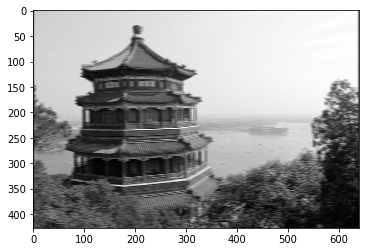

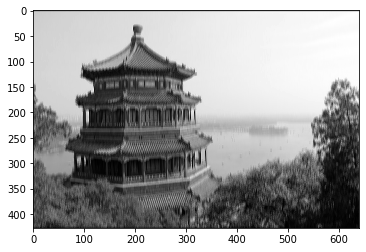

In [0]:
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
print()

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME").numpy()
plt.imshow(outputs[0, :, :, 1], cmap="gray") # only horizontal lines
plt.show()
plt.imshow(outputs[0, :, :, 0], cmap="gray") # only vertical lines
plt.show()

In [0]:
cnn = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="SAME", activation="relu")

A major problem with CNN is the memory requirements. Even though they are better than fully connected layers, there are still impressive quantities. Consider a layer with 5x5 filters, outputing 200 feature maps of size 150x100, with stride 1 and SAME padding. If the input is RGB then the parameters is (5 x 5 x 3 +1) x 200 = 15,200 parameters (the bias is the +1). But consider that each of the 200 outputs contains 150x100 neurons, and each of these neurons must compute the weighted sum of its 5x5x3 = 75 inputs. That is 225 million floating point multiplications! Now if the feature maps are float32, then the output will occupy 200x150x100x32 = 12 MB of RAM for a single instance. for a batch size of 100 that is 1.2GB!!! 

To solve memory issues you can try a combination of: reducing the batch size, reducing dimensionality by increasing the stride, or removing a few layers. You could also change to float16 or use multiple GPUs.

### Pooling

The goal is to subsample the input to reduce the load and memory usage. Just as before you define the size, stride, and padding type. However it has no weights, all it does is aggregate the inputs using some function like max or mean. It also introduces some invariance such that small shifts of objects or rotations are output regards of the shift. The downfall is the deconstructive nature: for a 2x2 kernel and stride of 2 the output is two times smaller in both directions, or 1/4 the size. 

In semantic segmentation, the task of classifying each pixel in an image depending on what object it belongs to, would obviously not perform well with invariance. Instead it requires equivariance, where a small change to the inputs leads to the same small change in the output.

In [0]:
max_pool = keras.layers.MaxPool2D(pool_size=2) # average pooling works too, but is less invariant and more noisy

Invariance works in the depth direction as well, so that the model is invariant to different features. This can be useful although is not common. One example is a filter learning rotation. Then the pooling would make it invariant to rotation. The only way to do a depth rotation is with the low level API, which can be customly used, or to wrap it in a lambda layer as shown.

In [0]:
depth_pool = keras.layers.Lambda(lambda x: tf.nn.max_pool(x, ksize=(1, 1, 1, 3), # [batch, height, width, depth]
                                                             strides = (1, 1, 1, 3),     # depth must be a divisor of the input depth
                                                             padding="VALID") 
                                )

Another common pooling layer is a *global average pooling layer* which works by computing the mean of each feature map. Then the output is just a single number per feature map and per instance. This is extremely deconstructive but it can make for a good output layer

In [0]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
# this is equal to this lambda layer
# global_avg_pool = keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=[1, 2]))

## Architectures

Normally a few convolutional layers (with ReLU) are stacked, then a pooling layer, then some more convolutional( +relu) then another pooling and so on. The image gets smaller as it progresses but it gets deeper with more feature maps. Then a fully connected layer or two and finally the output layer completes it. A common mistake is to use too large of kernels. Generally two 3x3 layers are better than one 5x5, except in the very first layer, this tends to be 5x5 or so with a stride of 2 or more.

In [0]:
from functools import partial


default_conv2d = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    default_conv2d(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),   # double the filters after pooling
    default_conv2d(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    default_conv2d(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax'),
])

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights = True)
model.fit(class_train, epochs = 50, validation_data=class_test, callbacks=[early_stopping])

Epoch 1/50
938/938 [==============================] - 24s 26ms/step - loss: 0.4709 - accuracy: 0.8278 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
938/938 [==============================] - 20s 21ms/step - loss: 0.2826 - accuracy: 0.8961 - val_loss: 0.3304 - val_accuracy: 0.8791
Epoch 3/50
938/938 [==============================] - 19s 20ms/step - loss: 0.2348 - accuracy: 0.9132 - val_loss: 0.2833 - val_accuracy: 0.8972
Epoch 4/50
938/938 [==============================] - 19s 20ms/step - loss: 0.2043 - accuracy: 0.9248 - val_loss: 0.2461 - val_accuracy: 0.9128
Epoch 5/50
938/938 [==============================] - 19s 21ms/step - loss: 0.1780 - accuracy: 0.9332 - val_loss: 0.2579 - val_accuracy: 0.9081
Epoch 6/50
938/938 [==============================] - 19s 20ms/step - loss: 0.1535 - accuracy: 0.9427 - val_loss: 0.2670 - val_accuracy: 0.9089
Epoch 7/50
938/938 [==============================] - 19s 20ms/step - loss: 0.1340 - accuracy: 0.9498 - val_loss: 0.2746 - val_a

In [0]:
model.get_weights()

## AlexNet

A model used to win the 2012 ImageNet ILSVRC challenge by a wide margin getting to 17% top 5 error rate using data augmentation, dropout, and local response normalization. This normalization makes strongly activated neurons inhibit other neurons located in the same position in nearby feature maps to ensure the strongest features are less noisy and encouraging different feature maps to specialize. This was applied immediately after the ReLU step in C1 and C3.

In [0]:
class AlexNet(keras.models.Model):
    def __init__(self, input_dim = [227, 227, 3], output_dim=1000, activation=None, **kwargs):
        super().__init__(kwargs)
        # normally kernel_size=11 and strides 4 but this does not work for the rock_paper_scissors dataset
        self.C1 = keras.layers.Conv2D(name="C1", filters=96, kernel_size=11, strides=4, padding="VALID", activation = "relu", input_shape=input_dim)
        self.S2 = keras.layers.MaxPool2D(name = "S2", pool_size=3, strides=2, padding="VALID")
        self.C3 = keras.layers.Conv2D(name="C3", filters=256, kernel_size=5, strides=1, padding="SAME", activation='relu')
        self.S4 = keras.layers.MaxPool2D(name="S4", pool_size=3, strides=2, padding="VALID")
        self.C5 = keras.layers.Conv2D(name="C5", filters=384, kernel_size=3, strides=1, padding="SAME", activation='relu')
        #self.C6 = keras.layers.Conv2D(name="C6", filters=384, kernel_size=3, strides=1, padding="SAME", activation='relu')
        self.C7 = keras.layers.Conv2D(name="C7", filters=256, kernel_size=3, strides=1, padding="SAME", activation='relu')
        self.Fl = keras.layers.Flatten()
        self.F8 = keras.layers.Dense(name='F8', units=4096, activation='relu')
        self.d1 = keras.layers.Dropout(0.5)
        self.F9 = keras.layers.Dense(name='F9', units=4096, activation='relu')
        self.d2 = keras.layers.Dropout(0.5)
        self.Out = keras.layers.Dense(name="Out", units=output_dim, activation=keras.activations.get(activation))
        
    def call(self, inputs):
        x = self.C1(inputs)
        x = tf.nn.local_response_normalization(x)
        x = self.S2(x)
        x = self.C3(x)
        x = tf.nn.local_response_normalization(x)
        x = self.S4(x)
        x = self.C5(x)
        #x = self.C6(x)
        x = self.C7(x)
        x = self.Fl(x)
        x = self.d1(x)
        x = self.F8(x)
        x = self.d2(x)
        x = self.F9(x)
        return self.Out(x)
    
    def get_config(self):
        base_config = super().get_config()
        return{**base_config, "output_dim" : output_dim, "activation": activation}

In [0]:
# model = AlexNet(input_dim = [227, 227, 3], output_dim = 1)
# optimizer = keras.optimizers.Nadam(1e-3)
# model.compile(loss='mae', optimizer='nadam', metrics=['mae'])
# early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights = True)
# model.fit(im_train, epochs = 50, validation_data=im_test, callbacks=[early_stopping])
 

## GoogLeNet

In [0]:
class InceptionMod(keras.layers.Layer):
    def __init__(self, output_dim = [128, 256, 64, 64, 128, 24], **kwargs):
        super().__init__(kwargs)
        # tier 1
        self.C1 = keras.layers.Conv2D(filters = output_dim[4], kernel_size=1, strides=1, padding='SAME', activation='relu')
        self.C2 = keras.layers.Conv2D(filters = output_dim[5], kernel_size=1, strides=1, padding='SAME', activation='relu')
        self.MXP = keras.layers.MaxPool2D(pool_size=3, strides=1, padding='SAME')
        
        self.C3 = keras.layers.Conv2D(filters = output_dim[0], kernel_size=1, strides=1, padding='SAME', activation='relu')
        self.C4 = keras.layers.Conv2D(filters = output_dim[1], kernel_size=3, strides=1, padding='SAME', activation='relu')
        self.C5 = keras.layers.Conv2D(filters = output_dim[2], kernel_size=5, strides=1, padding='SAME', activation='relu')
        self.C6 = keras.layers.Conv2D(filters = output_dim[3], kernel_size=1, strides=1, padding='SAME', activation='relu')
        
        
    def call(self, inputs):
        # w, x, y, z branches
        x = self.C1(inputs)
        y = self.C2(inputs)
        z = self.MXP(inputs)
        w = self.C3(inputs)
        x = self.C4(x)
        y = self.C5(y)
        z = self.C6(z)
        return tf.concat([w, x, y, z], axis=3) # depthwise concatenation

In [0]:
class GoogLeNet(keras.models.Model):
    def __init__(self, input_dim = [224, 224, 3], output_dim = 1000, activation=None, **kwargs):
        super().__init__(kwargs)
        self.C1 = keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='SAME', activation='relu', input_shape=input_dim)
        self.MP2 = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='SAME')
        self.C3 = keras.layers.Conv2D(filters=64, kernel_size=1, strides=1, padding='SAME', activation='relu')
        self.C4 = keras.layers.Conv2D(filters=192, kernel_size=3, strides=1, padding='SAME', activation='relu')
        self.MP5 = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='SAME')
        self.IM6 = InceptionMod(output_dim = [64, 128, 32, 32, 96, 16])
        self.IM7 = InceptionMod(output_dim = [128, 192, 96, 64, 128, 32])
        self.MP8 = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='SAME')
        self.IM9 = InceptionMod(output_dim = [192, 208, 48, 64, 96, 16])
        self.IM10 = InceptionMod(output_dim = [160, 224, 64, 64, 112, 24])
        self.IM11 = InceptionMod(output_dim = [128, 256, 64, 64, 128, 24])
        self.IM12 = InceptionMod(output_dim = [112, 288, 64, 64, 144, 32])
        self.IM13 = InceptionMod(output_dim = [256, 320, 128, 128, 160, 32])
        self.MP14 = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='SAME')
        self.IM15 = InceptionMod(output_dim = [256, 320, 128, 128, 160, 32])
        self.IM16 = InceptionMod(output_dim = [384, 384, 128, 128, 192, 48])
        self.GP17 = keras.layers.GlobalAveragePooling2D()
        self.FL = keras.layers.Flatten()
        self.DP18 = keras.layers.Dropout(0.5)
        self.FC19 = keras.layers.Dense(units=output_dim, activation=keras.activations.get(activation))

        
    def call(self, inputs):
        x = self.C1(inputs)
        x = self.MP2(x)
        x = tf.nn.local_response_normalization(x)
        x = self.C3(x)
        x = self.C4(x)
        x = tf.nn.local_response_normalization(x)
        x = self.MP5(x)
        x = self.IM6(x)
        x = self.IM7(x)
        x = self.MP8(x)
        x = self.IM9(x)
        x = self.IM10(x)
        x = self.IM11(x)
        x = self.IM12(x)
        x = self.IM13(x)
        x = self.MP14(x)
        x = self.IM15(x)
        x = self.IM16(x)
        x = self.GP17(x)
        x = self.FL(x)
        x = self.DP18(x)
        return self.FC19(x)
        
model = GoogLeNet(output_dim=1)

In [0]:
optimizer = keras.optimizers.Nadam(1e-4)

def extra_loss(y_true, pred):
    error = tf.abs(tf.subtract(y_true, pred)) * 2 + tf.keras.losses.MSE(y_true, pred)
    return error

model.compile(loss='mse', optimizer=optimizer)
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights = True)
model.fit(im_train, epochs = 50, validation_data=im_test, callbacks=[early_stopping])

Epoch 1/50
79/79 [==============================] - 34s 435ms/step - loss: 1.4302 - val_loss: 0.0000e+00
Epoch 2/50
79/79 [==============================] - 24s 302ms/step - loss: 1.0303 - val_loss: 0.9000
Epoch 3/50
79/79 [==============================] - 24s 301ms/step - loss: 0.8028 - val_loss: 0.7330
Epoch 4/50
79/79 [==============================] - 24s 299ms/step - loss: 0.6874 - val_loss: 0.6522
Epoch 5/50
79/79 [==============================] - 24s 301ms/step - loss: 0.6430 - val_loss: 0.6196
Epoch 6/50
79/79 [==============================] - 24s 300ms/step - loss: 0.6234 - val_loss: 0.5954
Epoch 7/50
79/79 [==============================] - 24s 300ms/step - loss: 0.6082 - val_loss: 0.5716
Epoch 8/50
79/79 [==============================] - 24s 300ms/step - loss: 0.5927 - val_loss: 0.5479
Epoch 9/50
79/79 [==============================] - 24s 300ms/step - loss: 0.5644 - val_loss: 0.5270
Epoch 10/50
79/79 [==============================] - 24s 300ms/step - loss: 0.5478 - va

## ResNet

Won the 2015 ILSVRC challenege by using a 152 layer deep CNN with skip connections. Instead of a training the network to target h(x) from x, by using a skip it instead forces it to predict f(x) = h(x) - x, which is called residual learning. Resnet-34, which uses 34 convolution and fc layers, will be modeled.

In [0]:
class ResUnit(keras.layers.Layer):
    def __init__(self, feature_maps, extra_strides=1, **kwargs):
        super().__init__(kwargs)
        self.C1 = keras.layers.Conv2D(filters=feature_maps, kernel_size=3, strides=extra_strides, padding='SAME', activation='relu')
        self.B2 = keras.layers.BatchNormalization()
        self.C3 = keras.layers.Conv2D(filters=feature_maps, kernel_size=3, strides=1, padding='SAME')
        self.B4 = keras.layers.BatchNormalization()
        self.skip_layers = []
        if extra_strides == 2:
            self.skip_layers = [keras.layers.Conv2D(filters=feature_maps, kernel_size=1, strides=2, padding='SAME', activation='relu'),
                                keras.layers.BatchNormalization()]
        self.Re = keras.layers.Activation('relu')
        
    def call(self, inputs):
        x = self.C1(inputs)
        x = self.B2(x)
        x = self.C3(x)
        x = self.B4(x)
        y = inputs
        for layer in self.skip_layers:
            y = layer(y)
            
        x = tf.add(x, y)
        return self.Re(x)

In [0]:
# has the problem of overfitting this simple dataset very quickly

class ResNet34(keras.models.Model):
    def __init__(self, input_dim=[224, 224, 3], output_dim=1000, activation=None, **kwargs):
        super().__init__(kwargs)
        self.C1 = keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='SAME', input_shape=input_dim)
        self.BN = keras.layers.BatchNormalization()
        self.Re = keras.layers.Activation('relu')
        self.M2 = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='SAME')
        self.R3 = [ResUnit(64) for _ in range(3)]
        self.R4 = ResUnit(128, extra_strides=2)
        self.R5 = [ResUnit(128) for _ in range(3)]
        self.R6 = ResUnit(256, extra_strides=2)
        self.R7 = [ResUnit(256) for _ in range(5)]
        self.R8 = ResUnit(512, extra_strides=2)
        self.R9 = [ResUnit(512) for _ in range(2)]
        self.GP = keras.layers.GlobalAveragePooling2D()
        self.FL = keras.layers.Flatten()
        self.F1 = keras.layers.Dense(64, activation='relu')
        self.DP = keras.layers.Dropout(0.5)
        self.FC = keras.layers.Dense(units=output_dim, activation=keras.activations.get(activation))
        
    def call(self, inputs):
        x = self.C1(inputs)
        x = self.BN(x)
        x = self.Re(x)
        x = self.M2(x)
        for layer in self.R3:
            x = layer(x)
        x = self.R4(x)
        for layer in self.R5:
            x = layer(x)
        x = self.R6(x)
        for layer in self.R7:
            x = layer(x)
        x = self.R8(x)
        for layer in self.R9:
            x = layer(x)
        x = self.GP(x)
        x = self.FL(x)
        x = self.F1(x)
        x = self.DP(x)
        return self.FC(x)
        
model = ResNet34(output_dim=1, activation=None)

In [0]:
optimizer = keras.optimizers.Adam(5e-6)
model.compile(loss='mae', optimizer=optimizer)
early_stopping = keras.callbacks.EarlyStopping(patience=8, restore_best_weights = True)
model.fit(im_train, epochs = 75, validation_data=im_test, callbacks=[early_stopping])

Epoch 1/75
79/79 [==============================] - 46s 576ms/step - loss: 1.5668 - val_loss: 0.0000e+00
Epoch 2/75
79/79 [==============================] - 20s 252ms/step - loss: 1.4582 - val_loss: 1.2504
Epoch 3/75
79/79 [==============================] - 20s 253ms/step - loss: 1.3379 - val_loss: 1.2476
Epoch 4/75
79/79 [==============================] - 20s 252ms/step - loss: 1.3288 - val_loss: 1.2887
Epoch 5/75
79/79 [==============================] - 20s 255ms/step - loss: 1.2432 - val_loss: 1.2853
Epoch 6/75
79/79 [==============================] - 20s 255ms/step - loss: 1.2036 - val_loss: 1.3036
Epoch 7/75
79/79 [==============================] - 20s 255ms/step - loss: 1.1324 - val_loss: 1.3017
Epoch 8/75
79/79 [==============================] - 20s 255ms/step - loss: 1.0854 - val_loss: 1.2240
Epoch 9/75
79/79 [==============================] - 20s 255ms/step - loss: 1.0502 - val_loss: 1.2126
Epoch 10/75
79/79 [==============================] - 20s 254ms/step - loss: 1.0087 - va

# RNN

The free book is no longer available, so at this point I will be working off of the github for the book, and learning more or less by reference. This is not ideal, but the book is not out yet and I cannot download the whole book for free, so this is what is left. 

In [0]:
# set up plotting
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# basic time series dataset
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5*np.sin((time - offset1) * (freq1 * 18 + 10))         # signal 1
    series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20))  # signal 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # noise
    return series[..., np.newaxis].astype(np.float32)

In [0]:
n_steps = 50
train_ind = 7000
valid_ind = 9000

series = generate_time_series(10000, n_steps + 1)

x_train, y_train = series[:train_ind, :n_steps], series[:train_ind, -1]
x_valid, y_valid = series[train_ind:valid_ind, :n_steps], series[train_ind:valid_ind, -1]
x_test, y_test = series[valid_ind:, :n_steps], series[valid_ind:, -1]
x_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

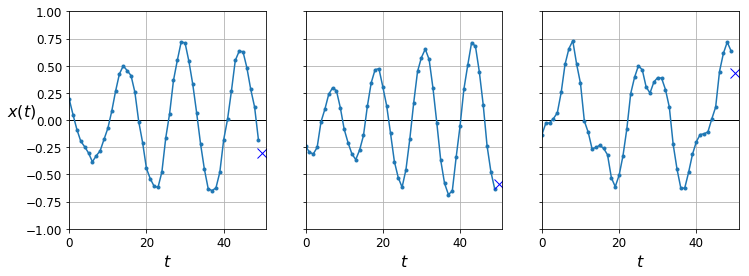

In [0]:
def plot_timeseries(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps+1, -1, 1])
    
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_timeseries(x_valid[col, :, 0], y_valid[col, 0], y_label=("$x(t)$" if col==0 else None))
    
plt.show()

In [0]:
# calculate baseline by just guessing the previous observation value as the current
y_pred = x_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.028736455

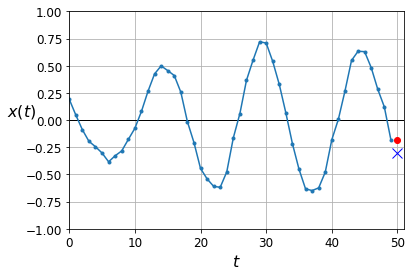

In [0]:
plot_timeseries(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0]) #plots the predicted next value in red
plt.show()

In [0]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[50, 1]),
                                 keras.layers.Dense(1) # predict one value from 50 previous
                                ])
optim = keras.optimizers.Nadam(1e-3)
epochs = 15
model.compile(loss='mse', optimizer=optim)
history = model.fit(x_train, y_train, epochs=epochs, validation_data = (x_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/15
7000/7000 [==============================] - 1s 93us/sample - loss: 0.1251 - val_loss: 0.0418
Epoch 2/15
7000/7000 [==============================] - 1s 73us/sample - loss: 0.0260 - val_loss: 0.0197
Epoch 3/15
7000/7000 [==============================] - 1s 73us/sample - loss: 0.0154 - val_loss: 0.0130
Epoch 4/15
7000/7000 [==============================] - 0s 71us/sample - loss: 0.0114 - val_loss: 0.0101
Epoch 5/15
7000/7000 [==============================] - 0s 70us/sample - loss: 0.0095 - val_loss: 0.0087
Epoch 6/15
7000/7000 [==============================] - 0s 71us/sample - loss: 0.0084 - val_loss: 0.0078
Epoch 7/15
7000/7000 [==============================] - 0s 70us/sample - loss: 0.0076 - val_loss: 0.0072
Epoch 8/15
7000/7000 [==============================] - 0s 71us/sample - loss: 0.0070 - val_loss: 0.0067
Epoch 9/15
7000/7000 [==============================] - 0s 69us/sample - loss: 0.0065 - val_loss: 0.0063
Epoch 1

In [0]:
model.evaluate(x_valid, y_valid)

2000/2000 [==============================] - 0s 36us/sample - loss: 0.0049


0.004912336738780141

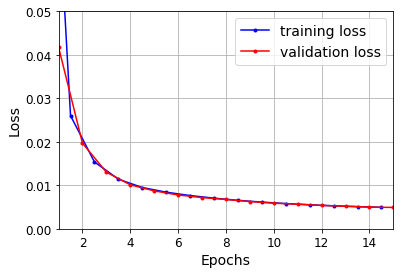

In [0]:
def plot_learning(loss, val_loss, epochs):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, epochs, 0, 0.05])
    plt.legend(loc='best', fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    
plot_learning(history.history['loss'], history.history['val_loss'], epochs)
plt.show()

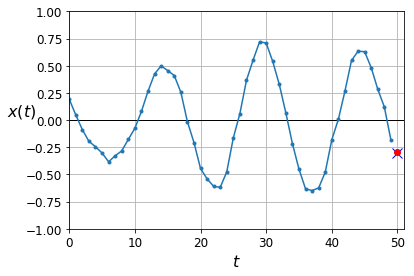

In [0]:
y_pred = model.predict(x_valid)
plot_timeseries(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [0]:
# simple RNN
model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])
                                ])
model.compile(loss='mse', optimizer=optim)
history = model.fit(x_train, y_train, epochs = epochs, validation_data = (x_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/15
7000/7000 [==============================] - 7s 964us/sample - loss: 0.1337 - val_loss: 0.0529
Epoch 2/15
7000/7000 [==============================] - 6s 862us/sample - loss: 0.0454 - val_loss: 0.0408
Epoch 3/15
7000/7000 [==============================] - 6s 853us/sample - loss: 0.0377 - val_loss: 0.0351
Epoch 4/15
7000/7000 [==============================] - 6s 861us/sample - loss: 0.0329 - val_loss: 0.0312
Epoch 5/15
7000/7000 [==============================] - 6s 864us/sample - loss: 0.0293 - val_loss: 0.0280
Epoch 6/15
7000/7000 [==============================] - 6s 851us/sample - loss: 0.0265 - val_loss: 0.0256
Epoch 7/15
7000/7000 [==============================] - 6s 854us/sample - loss: 0.0242 - val_loss: 0.0236
Epoch 8/15
7000/7000 [==============================] - 6s 858us/sample - loss: 0.0223 - val_loss: 0.0219
Epoch 9/15
7000/7000 [==============================] - 6s 874us/sample - loss: 0.0208 - val_loss: 0.020

# Extra Stuff

## Reinforcment Learning

In [0]:
!pip install huskarl
!pip install gym

import huskarl as hk
import gym


dummy_env = create_env()

model = keras.models.Sequential([keras.layers.Dense(16, activation='relu', input_shape = dummy_env.observation_space.shape),
                    keras.layers.Dense(16, activation='relu'),
                    keras.layers.Dense(16, activation='relu'),
                   ])

agent = hk.agent.DQN(model, actions=dummy_env.action_space.n, nsteps=2)

sim = hk.Simulation(create_env, agent)
sim.train(max_steps = 3000, visualize=True)
sim.test(max_steps=1000)

NoSuchDisplayException: ignored

## Generative Adversarial Network

Going through the TF tutorial on DCGAN using TF 2.0. There are a lot of useful features to remember, and cool ways to implement, like with custom loss functions and other useful features. Note the Conv2DTranspose layers are used to upsample the data

In [0]:
!pip install -q imageio

In [0]:
#mnist images useful for GANS/image generation
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape, test_images.shape)

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
train_images = train_images / 255.0 # normalize to [0, 1]
test_images = test_images / 255.0

print(train_images.shape, test_images.shape)

buffer_size = 60000
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(buffer_size).batch(batch_size)

bin_train_images = train_images.copy()
bin_train_images[bin_train_images >= 0.5] = 1
bin_train_images[bin_train_images < 0.5] = 0
bin_test_images = test_images.copy()
bin_test_images[bin_test_images >= 0.5] = 1
bin_test_images[bin_test_images < 0.5] = 0

bin_train_dataset = tf.data.Dataset.from_tensor_slices(bin_train_images).shuffle(buffer_size).batch(batch_size)
bin_test_dataset = tf.data.Dataset.from_tensor_slices(bin_test_images).shuffle(buffer_size).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


W0730 20:50:59.449642 140299794855808 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from IPython import display

### DCGAN

In [0]:
# generator model takes a seed as input and produces an image
class generator(keras.models.Model):
    def __init__(self, input_dim=(100,), **kwargs):
        super().__init__(kwargs)
        self.D1 = keras.layers.Dense(7*7*256, use_bias=False, input_shape=input_dim)
        self.BN2 = keras.layers.BatchNormalization()
        self.LR3 = keras.layers.LeakyReLU()
        self.RE4 = keras.layers.Reshape((7, 7, 256))
        
        self.C5 = keras.layers.Conv2DTranspose(filters=128, kernel_size= 5, strides=(1, 1), padding='SAME', use_bias=False)
        self.BN6 = keras.layers.BatchNormalization()
        self.LR7 = keras.layers.LeakyReLU()
        
        self.C8 = keras.layers.Conv2DTranspose(filters=64, kernel_size= 5, strides=(2, 2), padding='SAME', use_bias=False)
        self.BN9 = keras.layers.BatchNormalization()
        self.LR10 = keras.layers.LeakyReLU()
        
        #self.C11 = keras.layers.Conv2DTranspose(filters=64, kernel_size= 5, strides=(1, 1), padding='SAME', use_bias=False)
        #self.BN12 = keras.layers.BatchNormalization()
        #self.LR13 = keras.layers.LeakyReLU()
        
        self.C14 = keras.layers.Conv2DTranspose(filters=1, kernel_size= 5, strides=(2, 2), padding='SAME', use_bias=False, activation='tanh')
        
    def call(self, inputs, training=None):
        x = self.D1(inputs)
        x = self.BN2(x)
        x = self.LR3(x)
        x = self.RE4(x)
        x = self.C5(x)
        x = self.BN6(x)
        x = self.LR7(x)
        x = self.C8(x)
        x = self.BN9(x)
        x = self.LR10(x)
        #x = self.C11(x)
        #x = self.BN12(x)
        #x = self.LR13(x)
        x = self.C14(x)
        return x

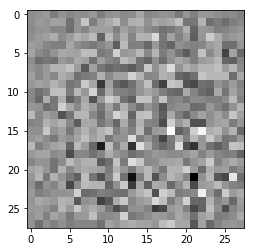

In [0]:
generator = generator(ipnut_dim=(100,))
noise = tf.random.normal([1, 100])
gen_im = generator(noise, training=False)
plt.imshow(gen_im[0, :, :, 0], cmap='gray')

So a random noisy image is created from the untrained model. Now the discriminator model can be made, and training can be done afterwards

In [0]:
class discriminator(keras.models.Model):
    def __init__(self, input_dim = [28, 28, 1], **kwargs):
        super().__init__(kwargs)
        self.C1 = keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='SAME', input_shape=input_dim)
        self.LR2 = keras.layers.LeakyReLU()
        self.DP3 = keras.layers.Dropout(0.4)
        
        self.C4 = keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='SAME')
        self.LR5 = keras.layers.LeakyReLU()
        self.DP6 = keras.layers.Dropout(0.4)
        
        #self.C7 = keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='SAME')
        #self.LR8 = keras.layers.LeakyReLU()
        #self.DP9 = keras.layers.Dropout(0.4)
        
        self.FL10 = keras.layers.Flatten()
        self.D11 = keras.layers.Dense(1)
        
    def call(self, inputs, training=None):
        x = self.C1(inputs)
        x = self.LR2(x)
        if training:
            x = self.DP3(x)
        x = self.C4(x)
        x = self.LR5(x)
        if training:
            x = self.DP6(x)
            
        #x = self.C7(x)
        #x = self.LR8(x)
        #x = self.DP9(x)
        
        x = self.FL10(x)
        x = self.D11(x)
        return x

In [0]:
discriminator = discriminator()
decision = discriminator(gen_im, training=False)
print(decision)

tf.Tensor([[0.00035973]], shape=(1, 1), dtype=float32)


In [0]:
# loss functions
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def disc_loss_fn(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def gen_loss_fn(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
# optimizers
gen_opt = keras.optimizers.Adam(1e-4)
disc_opt = keras.optimizers.Adam(1e-4)

In [0]:
# checkpoints
ckpt_dir = './training_checkpoints'
ckpt_prefix = os.path.join(ckpt_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gen_opt = gen_opt, disc_opt = disc_opt, generator=generator, discriminator=discriminator)

In [0]:
epochs = 70
noise_dim = 100
num_examples = 16

seed = tf.random.normal([num_examples, noise_dim])

In [0]:
# training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_imgs = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_imgs, training=True)
        
        gen_loss = gen_loss_fn(fake_output)
        disc_loss = disc_loss_fn(real_output, fake_output)
        
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
    for epoch in tf.range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # produce images for the GIF as it goes
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
    # inference now, not training
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, : , :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('images_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

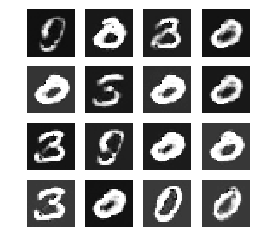

CPU times: user 8min 12s, sys: 1min 8s, total: 9min 21s
Wall time: 15min 28s


In [0]:
%%time
train(train_dataset, epochs)
# epoch 14-15 seem best after that they all start becoming 1/9

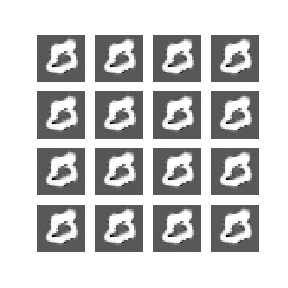

In [0]:
def display_image(epoch_no):
    return PIL.Image.open('images_at_epoch_{:04d}.png'.format(epoch_no))

display_image(29)

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

### Convolutional VAE

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (28, 28, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 2, activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides = 2, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])
        
        self.generative_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='SAME', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='SAME', activation='relu'),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='SAME'),
        ])
        
    @tf.function
    def sample(self, eps=None):
        if eps == None:
            eps = tf.random_normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    

VAES train by maximizing the evidence lower bound ELBO on the marginal log-likelihood
#### $\log{p(x)} \ge ELBO = \mathbb{E}_{q(z|x)}[\log{\frac{p(x, z)}{q(z|x)}}] $
this is simplified in practice for the single sample Monte Carlo estimate of the expectation:
#### $\log{p(x|z)} + \log{p(z)} - \log{q(z|x)} $ 
Where z is sampled from $q(z|x)$.

The KL term could be analystically computed but instead all three terms in the Monte Carlo estimator are incorporated

In [0]:

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = x_logit, labels = x)
    logpx_z = -tf.reduce_sum(cross_entropy, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

optimizer = tf.keras.optimizers.Adam(4e-4)

@tf.function
def compute_and_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

In [0]:
epochs = 200
latent_dim = 50
num_examples = 16

random_vector_for_gen = tf.random.normal(shape=[num_examples, latent_dim])
model = CVAE(latent_dim)

In [0]:
def generate_and_save_images(model, epoch, test_input):
    pred = model.sample(test_input)
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(pred.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(pred[i, :, :, 0], cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 13, Test set ELBO: -101.58546447753906, time elapse for current epoch 3.313839912414551


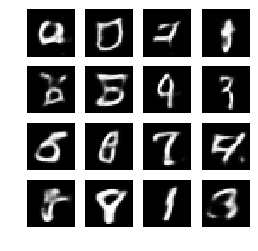

KeyboardInterrupt: ignored

In [0]:
import time


for epoch in range(1, epochs+1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_and_apply_gradients(model, train_x, optimizer)
        
    end_time = time.time()
    
    if epoch % 1 == 0:
        loss = tf.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch {}'.format(epoch, elbo, end_time-start_time))
        
        generate_and_save_images(model, epoch, random_vector_for_gen)
        

In [0]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

## Bayesian Neural Networks

In [0]:
# build input data pipeline,
# important because we want to feed it alternations between training and test data

def build_input_pipeline(batch_size, holdout_size):
    
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    print(train_images.shape, test_images.shape)

    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
    train_images = train_images / 255.0 # normalize to [0, 1]
    test_images = test_images / 255.0

    print(train_images.shape, test_images.shape)

    buffer_size = 60000

    train_dataset = tf.data.Dataset.from_tensor_slices(train_images, tf.int16(train_labels)).shuffle(buffer_size, reshuffle_each_iteration=True).repeat().batch(batch_size)
    train_iterator = tf.compat.v1.data.make_one_shot_iterator(train_dataset)
    
    
    # frozen iterator
    test_dataset = tf.data.Dataset.from_tensor_slices(test_images, tf.int16(test_labels)).take(heldout_size).repeat().batch(batch_size)
    test_iterator = tf.compat.v1.data.make_one_shot_iterator(test_dataset)

    handle = tf.compat.v1.placeholder(tf.string, shape=[])
    feed_iterator = tf.compat.v1.data.Iterator.from_string_handle(handle, train_dataset.output_types, train_dataset.output_shapes)
    
    images, labels = feeed_iterator.get_next()
    
    num_examples = train_images.shape[0]
    
    return images, labels, handle, train_iterator, test_iterator, num_examples


In [0]:
import tensorflow_probability as tfp

(images, labels, handle, train_iter, test_iter, num_examples) = build_input_pipeline(32, 100)

with tf.compat.v1.name_scope("BNN", values=[images])
    model = tf.keras.model.Sequential([tf.keras.layers.Reshape([28, 28, 1]),
                                       tfp.layers.Convolution2DFlipout(64, kernel_size=5, padding='SAME', activation=tf.nn.relu),
                                       tf.keras.layers.MaxPooling2D(pool_size= [2, 2], strides = [2,2], padding='SAME'),
                                       tf.keras.layers.Flatten(),
                                       tfp.layers.DenseFlipout(10)
                                      ])

    logits = model(images)
    labels_dist = tfp.distributions.Categorical(logits=logits)
    
neg_log_likelihood = -tf.reduce_mean(input_tensor=labels_dist.log_prob(labels))

kl = sum(model.losses) / num_examples
elbo = neg_log_likelihood + kl



Must minimize Kullback-Liebler (KL) divergence. This can be done by sampling the approximation function q(w|D) to produce a tractable function:


---


##$\mathcal{F}(\mathcal{D}, \theta) \approx \sum^n_{i=1} \log{q_\theta(w^{(i)}|\mathcal{D})} - \log{p(w^{(i)})} - \log{p(\mathcal{D}|w^{(i)})}$


---


for sampled weights w for the backprogagation to learn the posterior distribution.

## Adversarial Autoencoder

An adversarial autoencoder relies on the fundamentals of generative adversarial networks (GANS) and Variational Autoencoders. Instead of trying to minimize the KL divergence from before,but rather it uses a discriminator to discriminate the latent codes from the desired distribution. This allows it to learn to generate samples which are similar to the desired distribution. See this [LINK](https://medium.com/@a.mirzaei69/adversarial-autoencoders-on-mnist-dataset-python-keras-implementation-5eeafd52ab21) for reference, or the [original paper](https://arxiv.org/pdf/1511.05644.pdf)

# Notes

Important take aways... 
Nadam optimizer, early stopping, from functools import partial for reduce code writing, save subclassed models as .h5py and it will work